<h1 align="left">Exploratory Data Analysis</h1>

<p align="left"><i>PASTIS24 Dataset</i></p>

<p align="left">
  ITESM
  
  <a href="https://www.linkedin.com/in/juanrtato/">Juan Ricardo Albarracin B.</a>
  <br>
  <a href="">Luis Ángel Oporto Añacato.</a>
  <br>
  <a href="">David Alexis García Espinosa.</a>
  <br>
  <b>Last updated:</b> <i>04/05/2025</i>
  <br><br>
  <a target="_blank">
    <img src="https://github.com/QData/TextAttack/workflows/Github%20PyTest/badge.svg" alt="Testing">
  </a>
  <a href="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000">
    <img src="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000" alt="Version" height="18">
  </a>
</p><br>

Importing libraries

In [30]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts')))
from utils import CustomSequenceDataset

In [44]:
import random
import ast
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import json
import matplotlib.colors as mcolors

In [32]:
!pwd

/home/juanrtato/Documents/Proyecto Integrador/crop-image-deepanalysis/notebooks


Loading the dataset PASTIS24

In [33]:
# Set the correct path to the CSV file and root directory
# Download the dataset from https://drive.google.com/drive/folders/1Lm0repzD_1NVcECsrwF8Q3bP2XEp2a0y
dataset = CustomSequenceDataset(
    csv_path='../datalake/PASTIS24/fold-paths/folds_1_123_paths.csv',
    root_dir='../datalake/PASTIS24'
)

In [34]:
# Iterate through the dataset to get inputs, labels, masks and doy (day of year)
batch_generator = iter(dataset.get_batches())
batch = next(batch_generator)
print(len(batch))
print(batch[0]['inputs'].shape) 
print(batch[0]['labels'].shape)  
print(batch[0]['unk_masks'].shape)  
print(batch[0]['doy'].shape)  

32
(60, 24, 24, 10)
(3, 24, 24)
(60,)
(60,)


Visualize a sample from the batch

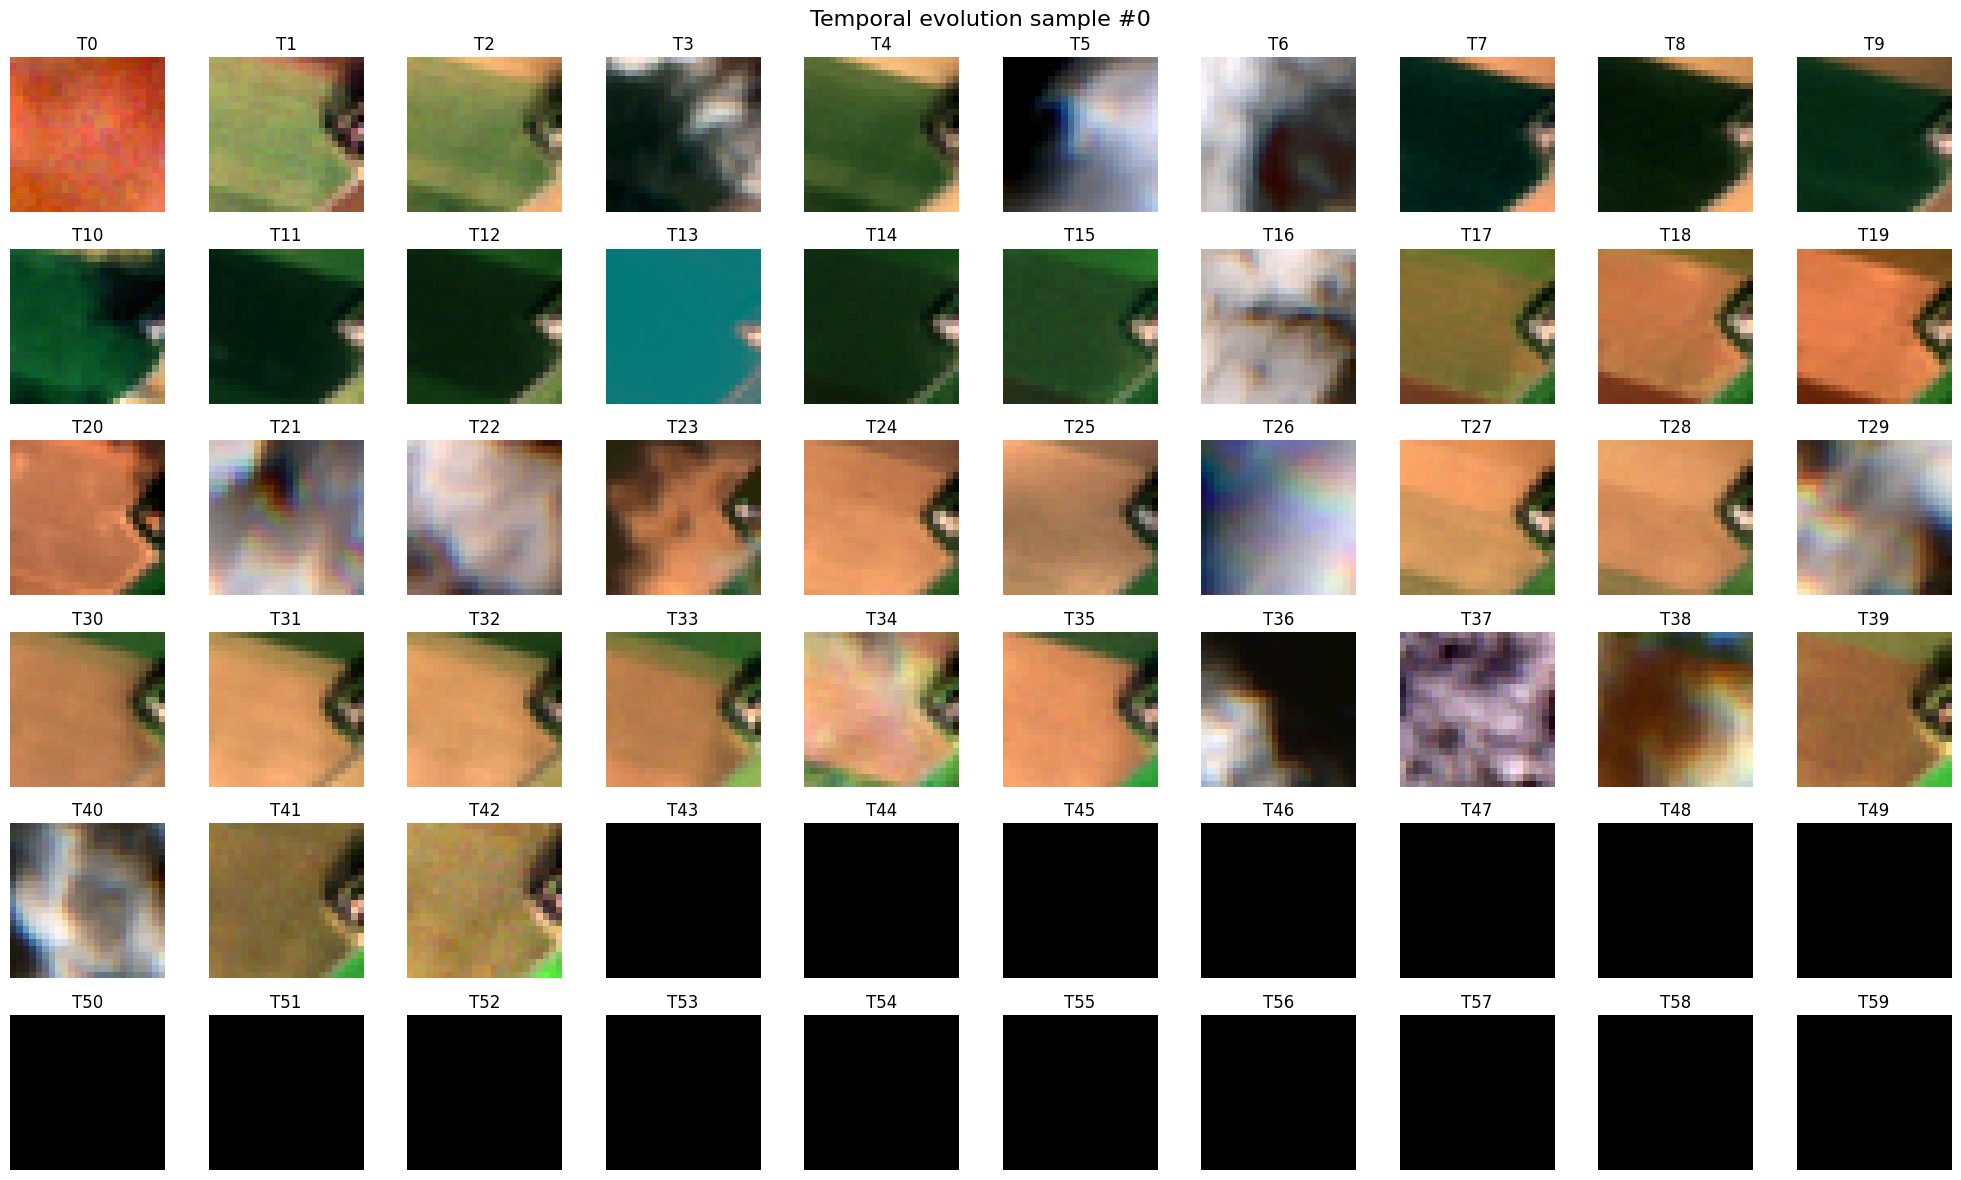

In [47]:
inputs = batch
#random_idx = random.randint(0, len(batch) - 1)
random_idx = 15
sample = batch[random_idx]['inputs'] 
rgb_indices = [2, 1, 0]
fig, axes = plt.subplots(6, 10, figsize=(20, 12))
fig.suptitle(f"Temporal evolution sample #{0}", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = sample[i] 
    rgb = img[:, :, rgb_indices]
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-5)

    ax.imshow(rgb)
    ax.set_title(f'T{i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

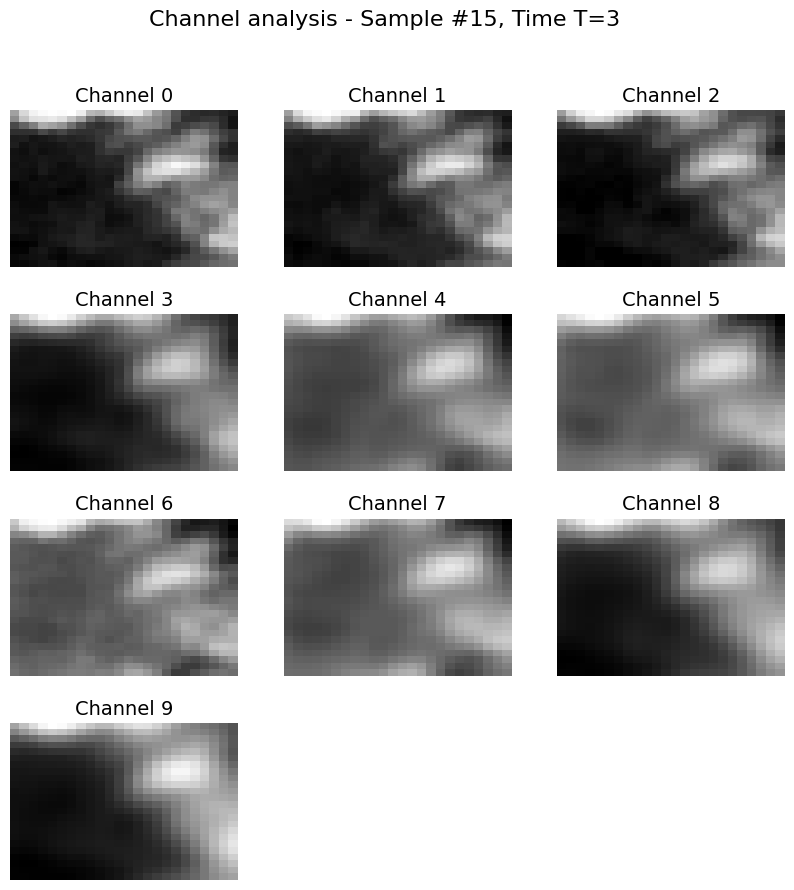

In [48]:
n_time, height, width, n_bands = sample.shape 
cols = 3
t = 3
rows = (n_bands + cols - 1) // cols 

fig, axs = plt.subplots(rows, cols, figsize=(10, 10)) 
for band in range(n_bands):
    ax = axs[band // cols, band % cols]  
    img = sample[t, :, :, band]  
    
    img = (img - img.min()) / (img.max() - img.min() + 1e-5)

    ax.imshow(img, cmap='gray', aspect='auto')
    ax.set_title(f'Channel {band}', fontsize=14)
    ax.axis('off')

for i in range(n_bands, rows * cols):
    fig.delaxes(axs.flatten()[i])

plt.subplots_adjust(hspace=0.3, wspace=0.2)

fig.suptitle(f"Channel analysis - Sample #{random_idx}, Time T={t}", fontsize=16)
plt.show()


**Bands 0 (Blue), 1 (Green), and 2 (Red)**: These images show tonal differences that may represent variations in surface type (e.g., agricultural areas vs. built-up areas). However, they do not highlight vegetated areas as much as other bands (such as NIR).

**Bands 3, 4, 5, and 7 (Red Edge)**: These images appear blurrier compared to the visible bands, and they are designed to analyze specific vegetation characteristics rather than sharp visual details. In these bands, subtle differences in agricultural fields are noticeable; these bands are capturing variability in leaf structure and vegetation health.

**Band 6 (NIR)**: This image shows high contrast in areas with vegetation, as NIR is strongly reflected by healthy plants. Bright areas represent dense and healthy vegetation, while darker zones could be soil, structures, or less dense vegetation. The contrast in this band allows for good differentiation of vegetation from other surfaces. It can be seen that the darker plots in this band are those that, in true color, appear as dry soil or with sparse vegetation, given their dull color.

**Bands 8 and 9 (SWIR)**: These images have a lower level of detail but can be used to infer differences in moisture content. Brighter areas in the SWIR bands may represent dry soils or vegetation with lower water content, while darker areas may have higher water content or be non-vegetated surfaces. These bands are useful for detecting water stress in vegetation or soil moisture. It can be seen that the previously mentioned dull areas, which in Band 6 lack dense and healthy vegetation, indicate dry soil or vegetation.

To explore the relationship between the bands further, we can create a correlation matrix.

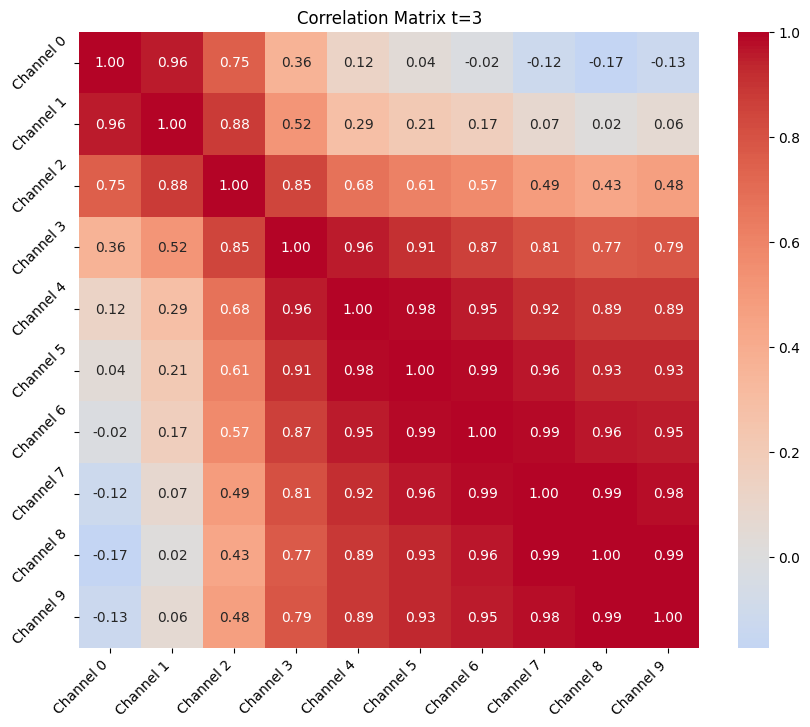

In [49]:
t = 3 
flattened_channels = [sample[t, channel].flatten() for channel in range(sample.shape[-1])]
correlation_matrix = np.corrcoef(flattened_channels)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f",
            xticklabels=[f'Channel {i}' for i in range(sample.shape[-1])],
            yticklabels=[f'Channel {i}' for i in range(sample.shape[-1])])

plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=45, ha='right')

plt.title(f'Correlation Matrix t={t}')
plt.show()


As shown in the images, it can be seen that the first four bands (0, 1, 2, and 3) have very low or negative correlations with bands 4, 5, 6, and 7. In particular, bands 0 and 2 have notably negative correlations with these bands.

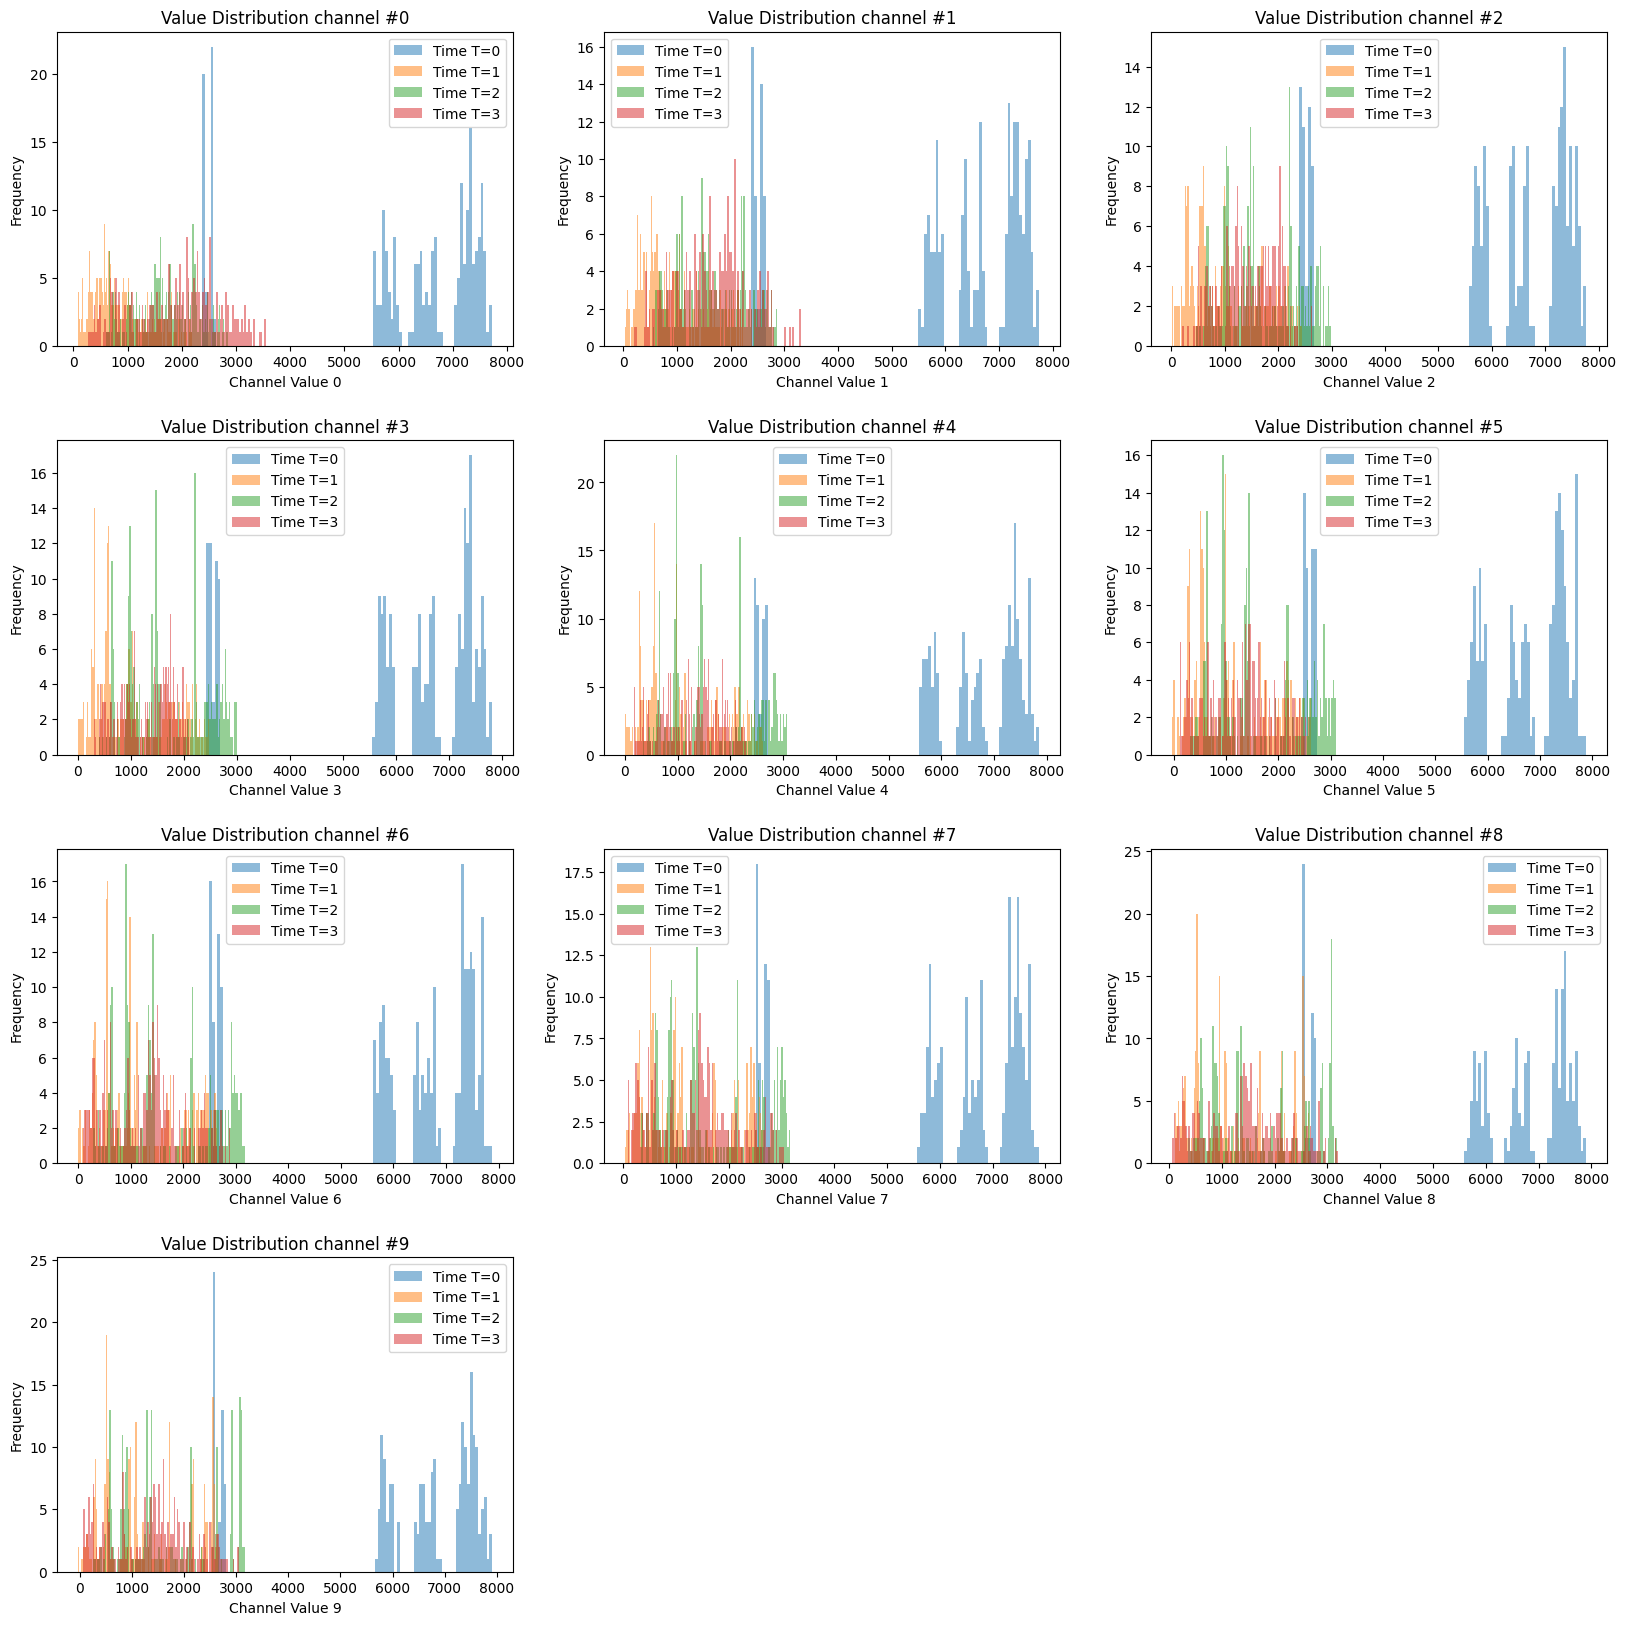

In [50]:
cols = 3
rows = (n_bands + cols - 1) // cols  
time_indices = [0, 1, 2, 3] 
fig, axs = plt.subplots(rows, cols, figsize=(20, rows * 5))

for band in range(n_bands):
    ax = axs[band // cols, band % cols] 
    for t in time_indices:
        band_values = sample[t, band].flatten()
        ax.hist(band_values, bins=100, alpha=0.5, label=f'Time T={t}')
    ax.set_title(f'Value Distribution channel #{band}')
    ax.set_xlabel(f'Channel Value {band}')
    ax.set_ylabel('Frequency')
    ax.legend() 


for i in range(n_bands, rows * cols):
    fig.delaxes(axs.flatten()[i])

plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.show()


These histograms illustrate the spatial structure and variability within each channel, offering insights into the dominant land cover types or surface characteristics captured in the image at each time point.

The x-axis values represent the intensity levels of each channel, corresponding to reflectance measured at a specific wavelength (which varies depending on the channel). In other words, these values indicate the "amount of light" reflected by each pixel in that channel. The histograms show the frequency of each reflectance value across all image pixels. Higher frequencies mean that many pixels share that reflectance level, while lower frequencies indicate rarer intensity values.

The most notable acquisition time is time 0, which consistently shows higher reflectance values across all channels. This is likely due to cloud cover at the time of capture, which increases overall brightness in the scene.

In the first four channels (0, 1, 2, and 3), reflectance tends to be lower, resulting in darker images. This is reflected in the histograms, which are right-skewed—indicating a concentration of lower intensity values. While this skewness appears across all channels, it is more pronounced in these initial four.

At times 2 and 3, the histograms tend to show multiple defined peaks and slightly wider distributions (excluding time 0), suggesting a broader range of reflectance values and slightly higher overall reflectance than other time steps.

From a channel-specific interpretation: since in channels 8 and 9 the darker areas typically correspond to regions with higher soil moisture, it can be inferred that the plots contain moderately moist soils for the analyzed times (excluding time 0), as the reflectance values are low but not at extreme levels.

Similarly, most plots appear to have little dense and healthy vegetation, as evidenced by the consistently dark values in the relevant vegetation-sensitive channels from time 1 onward.



### Labels

In [137]:
with open("../datalake/colormap.txt", "r") as txt_file:
    colormap = txt_file.readlines()
colormap = [ast.literal_eval(line.strip().rstrip(',')) for line in colormap]

In [138]:
with open("../datalake/label_names_es.json", "r") as json_file:
    class_mapping = json.load(json_file)
class_mapping

{'0': 'Fondo',
 '1': 'Pradera',
 '2': 'Trigo blando de invierno',
 '3': 'Maíz',
 '4': 'Cebada de invierno',
 '5': 'Colza de invierno',
 '6': 'Cebada de primavera',
 '7': 'Girasol',
 '8': 'Vid',
 '9': 'Remolacha',
 '10': 'Triticale de invierno',
 '11': 'Trigo duro de invierno',
 '12': 'Frutas, verduras, flores',
 '13': 'Papas',
 '14': 'Forraje leguminoso',
 '15': 'Soja',
 '16': 'Huerto',
 '17': 'Cereal mixto',
 '18': 'Sorgo',
 '19': 'Etiqueta vacía'}

In [139]:
label = batch[random_idx]['labels'] 
label.shape

(3, 24, 24)

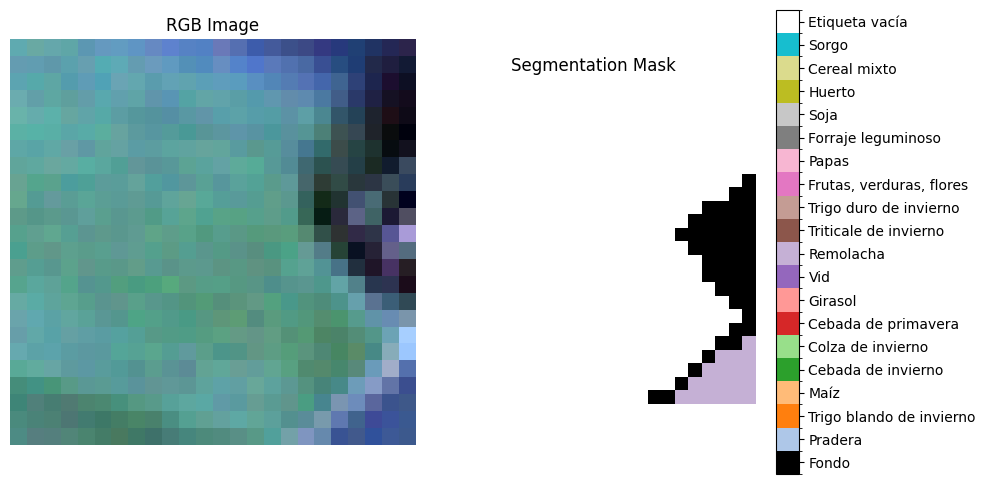

In [140]:
def plot_seg_mask(image, mask_array, colormap, class_labels=None):
    """
    Plots an RGB image alongside a segmentation mask with a custom colormap.
    
    Args:
        image (np.ndarray): Sample.
        mask_array (np.ndarray): 2D array representing the segmentation mask.
        colormap (list): List of RGB tuples for the colormap.
        class_labels (dict, optional): Dictionary mapping class indices to labels.
    """
    rgb_image = image[:, :, :3]
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
    
    custom_cmap = mcolors.ListedColormap(colormap)
    bounds = np.arange(len(colormap) + 1) - 0.5
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(rgb_image)
    axes[0].set_title("RGB Image")
    axes[0].axis("off")
    axes[0].set_aspect("equal")
    
    cax = axes[1].imshow(mask_array, cmap=custom_cmap, norm=norm)
    cbar = fig.colorbar(cax, ax=axes[1], ticks=np.arange(len(colormap)))
    cbar.set_ticks(np.arange(len(colormap)))
    cbar.set_ticklabels(list(class_labels.values()))
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Plot the segmentation mask
plot_seg_mask(sample[1], label[0], colormap, class_mapping)

In [141]:
label.shape

(3, 24, 24)

In [142]:
semantic = label[0]  
instances = label[1]
print("Unique values of semantic layer:", np.unique(semantic))

Unique values of semantic layer: [ 0  9 19]


## Bar chart of the classes

In [143]:
def get_area_per_class(seg_mask: np.array, label_names: dict, area_px_m2: int = 100) -> dict:
    """
    Get the area (in m2) of each class in the segmentation mask.
    Args:
        seg_mask (np.ndarray): Segmentation mask with class labels.
        classes (dict): Dictionary mapping class labels to their respective names.
        area_px_m2 (float): Area of one pixel in square meters.
        label_names (dict): Dictionary mapping class indices to labels.
    
    Returns:
        dict: Dictionary with class labels as keys and their respective areas in square meters.
    """
    classes, counts = np.unique(seg_mask, return_counts=True)
    if label_names is not None:
        areas_per_class = {
            label_names.get(str(int(crop_class))): int(count * area_px_m2)
            for crop_class, count in zip(classes, counts)
        }
        return areas_per_class

    return {
            str(int(crop_class)): int(count * area_px_m2)
            for crop_class, count in zip(classes, counts)
        }

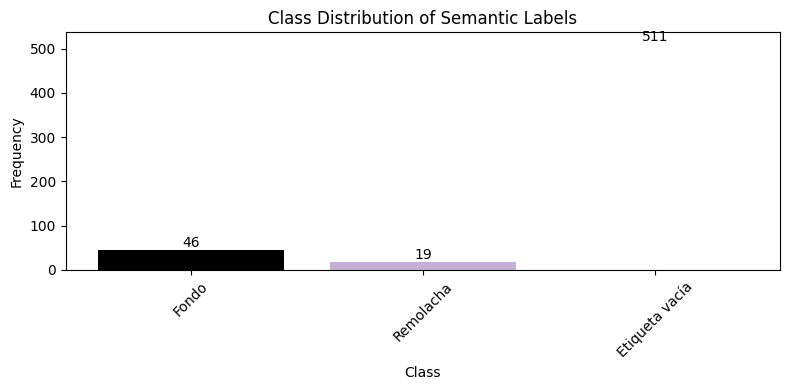

In [144]:
unique_classes, counts = np.unique(semantic, return_counts=True)
class_names = [class_mapping.get(str(cls), "Unknown") for cls in unique_classes]
colors = [colormap[cls] for cls in unique_classes]
plt.figure(figsize=(8, 4))
bars = plt.bar(class_names, counts, color=colors)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(count), 
             ha='center', va='bottom', fontsize=10)

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Distribution of Semantic Labels")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

For this sample, it is evident that a large portion of the captured space is identified as unknown, background and as void layer.

## Pie chart of Agricultural Distribution

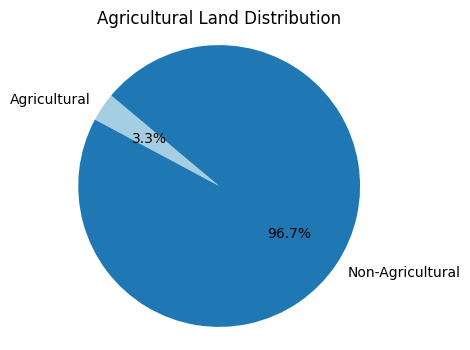

In [145]:
areas_agricolas = get_area_per_class(semantic, class_mapping, area_px_m2=100)
total_area = sum(list(areas_agricolas.values()))
agricultural_classes = [
    'Pradera',
    'Trigo blando de invierno',
    'Maíz',
    'Cebada de invierno',
    'Colza de invierno',
    'Cebada de primavera',
    'Girasol',
    'Vid',
    'Remolacha',
    'Triticale de invierno',
    'Trigo duro de invierno',
    'Frutas, verduras, flores',
    'Papas',
    'Forraje leguminoso',
    'Soja',
    'Huerto',
    'Cereal mixto',
    'Sorgo',
]
agricultural_area = sum([areas_agricolas.get(cls, 0) for cls in agricultural_classes])
non_agricultural_area = total_area - agricultural_area

# Calculate percentages
percentages = {'Agricultural': (agricultural_area / total_area) * 100,
               'Non-Agricultural': (non_agricultural_area / total_area) * 100}

labels = list(percentages.keys())
sizes = list(percentages.values())

# Create pie chart
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Agricultural Land Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


# Structural Analysis

In [17]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.stats as stats # Funciones estadísticas
from scipy.optimize import curve_fit, minimize # Ajuste de modelos y optimización
from scipy.special import kv, gamma # Funciones especiales para el modelo Matérn
from scipy.spatial.distance import pdist, squareform # Cálculo de distancias y matrices de distancia

from shapely.geometry import shape # Manipulación de geometrías espaciales

## Paso 1: Verificación de los datos

In [18]:
# Leer el archivo
metadata_path = "/kaggle/input/pastis/PASTIS/metadata.geojson"

with open(metadata_path, 'r') as f:
    metadata_json = json.load(f)

# Extraer coordenadas de los centroides
data = []
for feature in metadata_json["features"]:
    properties = feature["properties"]
    geometry = feature["geometry"]
    
    # Convertir la geometría a un objeto shapely para calcular el centroide
    geom_shape = shape(geometry)
    centroid = geom_shape.centroid
    
    # Agregar coordenadas del centroide a los datos
    properties["centroid_x"] = centroid.x
    properties["centroid_y"] = centroid.y
    data.append(properties)

# Convertir a DataFrame para revisar la estructura
metadata_df = pd.DataFrame(data)
# metadata_df[['ID_PATCH', 'centroid_x', 'centroid_y', 'Fold', 'Parcel_Cover']].head()
# metadata_df.shape
metadata_df.head(20)

Fold  ID_PATCH  N_Parcel  Parcel_Cover    TILE  \
0      1     10000       119      0.808032  t30uxv   
1      2     10001       111      0.501986  t30uxv   
2      4     10002       131      0.638722  t30uxv   
3      5     10003        75      0.866824  t30uxv   
4      4     10004        46      0.204906  t30uxv   
5      3     10005        88      0.667172  t30uxv   
6      3     10006        93      0.752556  t30uxv   
7      1     10007        77      0.276382  t30uxv   
8      4     10008        23      0.140183  t30uxv   
9      3     10009        64      0.970282  t30uxv   
10     5     10010        92      0.838699  t30uxv   
11     4     10011        91      0.674014  t30uxv   
12     5     10012        55      0.939660  t30uxv   
13     3     10013        92      0.820805  t30uxv   
14     4     10014        53      0.620790  t30uxv   
15     2     10015        16      0.123914  t30uxv   
16     3     10016        75      0.835466  t30uxv   
17     5     10017        44      0.726348  t30uxv   
18     5     10018        94      0.897735  t30uxv   
19     4     10019        47      0.652158  t30uxv   

                                             dates-S2     id     centroid_x  \
0   {'0': 20180924, '1': 20180929, '2': 20181004, ...  10000  392093.995308   
1   {'0': 20180924, '1': 20180929, '2': 20181004, ...  10001  368217.754810   
2   {'0': 20180924, '1': 20180929, '2': 20181004, ...  10002  389539.655180   
3   {'0': 20180924, '1': 20180929, '2': 20181004, ...  10003  455816.973055   
4   {'0': 20180924, '1': 20180929, '2': 20181004, ...  10004  365368.803827   
5   {'0': 20180924, '1': 20180929, '2': 20181004, ...  10005  365173.084538   
6   {'0': 20180924, '1': 20180929, '2': 20181004, ...  10006  368118.797360   
7   {'0': 20180924, '1': 20180929, '2': 20181004, ...  10007  394549.634663   
8   {'0': 20180924, '1': 20180929, '2': 20181004, ...  10008  365172.425836   
9   {'0': 20180924, '1': 20180929, '2': 20181004, ...  10009  453363.239672   
10  {'0': 20180924, '1': 20180929, '2': 20181004, ...  10010  375290.987071   
11  {'0': 20180924, '1': 20180929, '2': 20181004, ...  10011  367726.274709   
12  {'0': 20180924, '1': 20180929, '2': 20181004, ...  10012  450414.115337   
13  {'0': 20180924, '1': 20180929, '2': 20181004, ...  10013  369592.079347   
14  {'0': 20180924, '1': 20180929, '2': 20181004, ...  10014  445397.429728   
15  {'0': 20180924, '1': 20180929, '2': 20181004, ...  10015  365468.569252   
16  {'0': 20180924, '1': 20180929, '2': 20181004, ...  10016  461009.444247   
17  {'0': 20180924, '1': 20180929, '2': 20181004, ...  10017  447762.273891   
18  {'0': 20180924, '1': 20180929, '2': 20181004, ...  10018  367038.447370   
19  {'0': 20180924, '1': 20180929, '2': 20181004, ...  10019  448345.758307   

      centroid_y  
0   6.956118e+06  
1   6.879610e+06  
2   6.956315e+06  
3   6.916502e+06  
4   6.909365e+06  
5   6.890116e+06  
6   6.911722e+06  
7   6.954644e+06  
8   6.906811e+06  
9   6.917977e+06  
10  6.938144e+06  
11  6.889920e+06  
12  6.913069e+06  
13  6.914177e+06  
14  6.898050e+06  
15  6.877253e+06  
16  6.900691e+06  
17  6.911991e+06  
18  6.914374e+06  
19  6.902957e+06

In [19]:
import matplotlib.pyplot as plt

# Estadísticas descriptivas
print("Estadísticas de Parcel Cover:")
print(metadata_df['Parcel_Cover'].describe())

Estadísticas de Parcel Cover:
count    2433.000000
mean        0.616989
std         0.216102
min         0.030340
25%         0.470243
50%         0.655637
75%         0.792562
max         0.988299
Name: Parcel_Cover, dtype: float64


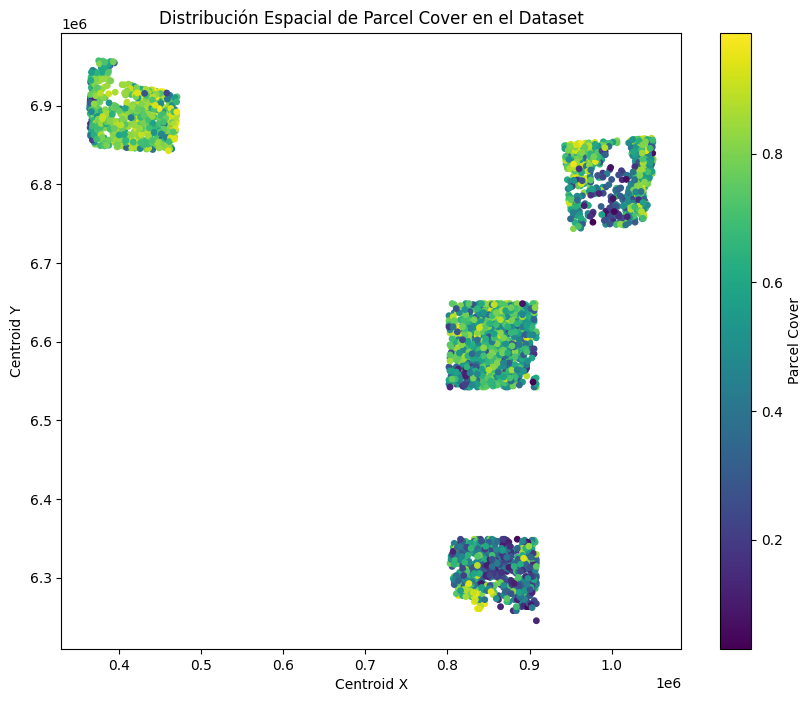

In [20]:
plt.figure(figsize=(10, 8))
plt.scatter(metadata_df['centroid_x'], metadata_df['centroid_y'], 
            c=metadata_df['Parcel_Cover'], cmap='viridis', s=15)
plt.colorbar(label='Parcel Cover')
plt.xlabel('Centroid X')
plt.ylabel('Centroid Y')
plt.title('Distribución Espacial de Parcel Cover en el Dataset')
plt.show()

In [21]:
# Separando el dataset por Fold

fold_data = {f: metadata_df[metadata_df['Fold'] == f] for f in metadata_df['Fold'].unique()}

for f, df in fold_data.items():
    print(f"Fold {f} tiene {len(df)} parches")

Fold 1 tiene 487 parches
Fold 2 tiene 494 parches
Fold 4 tiene 482 parches
Fold 5 tiene 496 parches
Fold 3 tiene 474 parches


Está balanceado ✨

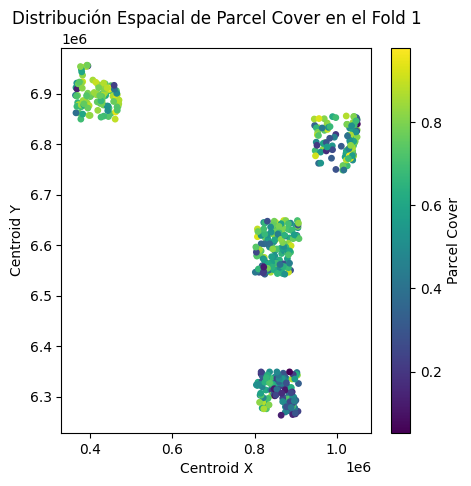

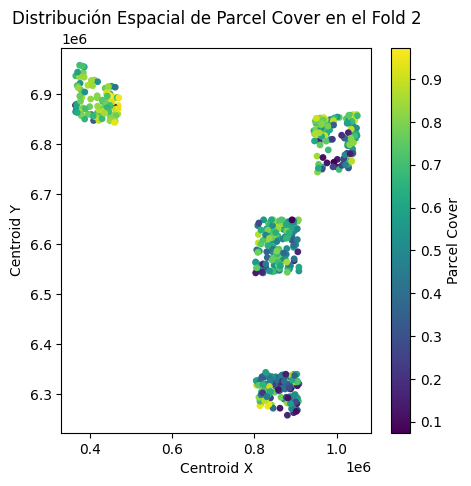

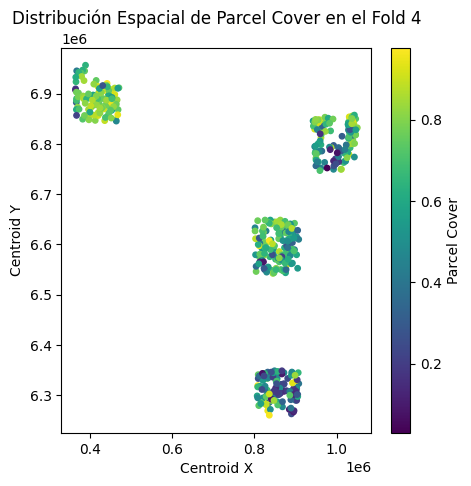

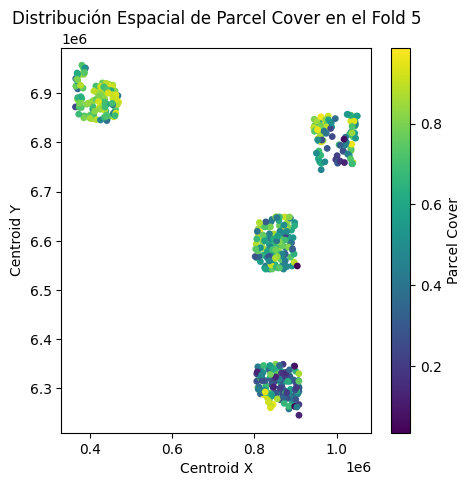

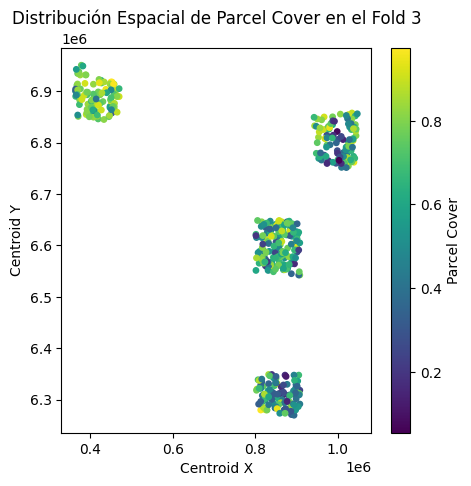

In [22]:
for f, df in fold_data.items():
    plt.figure(figsize=(5, 5))
    plt.scatter(df['centroid_x'], df['centroid_y'], 
                c=df['Parcel_Cover'], cmap='viridis', s=15)
    plt.colorbar(label='Parcel Cover')
    plt.xlabel('Centroid X')
    plt.ylabel('Centroid Y')
    plt.title(f'Distribución Espacial de Parcel Cover en el Fold {f}')
    plt.show()

In [23]:
print("Rango de centroid_x:", metadata_df['centroid_x'].min(), "-", metadata_df['centroid_x'].max())
print("Rango de centroid_y:", metadata_df['centroid_y'].min(), "-", metadata_df['centroid_y'].max())

# Definir manualmente los límites para cada bloque

def assign_block(row):
    x, y = row['centroid_x'], row['centroid_y']
    
    if x < 500000 and y > 6800000:
        return 1  # Bloque superior izquierdo
    elif x >= 900000 and y > 6700000:
        return 2  # Bloque superior derecho
    elif x >= 700000 and x <= 920000 and y <= 6700000 and y >= 6500000:
        return 3  # Bloque central
    elif x >= 700000 and x <= 920000 and y >= 6400000:
        return 4  # Bloque inferior central
    else:
        return 0  # Para depuración, en caso de que no entre en ningún bloque

# Aplicar la función para asignar bloques
metadata_df['Block'] = metadata_df.apply(assign_block, axis=1)

# Verificar la asignación de bloques
print(metadata_df[['centroid_x', 'centroid_y', 'Block']].head())

# Revisar la cantidad de parches en cada bloque para asegurar que se asignaron correctamente
metadata_df['Block'].value_counts()


Rango de centroid_x: 364387.12454066146 - 1050513.958739785
Rango de centroid_y: 6245116.391171012 - 6957399.285190922
      centroid_x    centroid_y  Block
0  392093.995308  6.956118e+06      1
1  368217.754810  6.879610e+06      1
2  389539.655180  6.956315e+06      1
3  455816.973055  6.916502e+06      1
4  365368.803827  6.909365e+06      1


Block
3    723
0    623
2    556
1    531
Name: count, dtype: int64

Ya no está balanceado :)

In [24]:
# Definir manualmente los límites para cada bloque observados
def assign_block(row):
    x, y = row['centroid_x'], row['centroid_y']
    
    # Ajuste de límites para los cuatro bloques observados
    if x < 520000 and y > 6800000:
        return 1  # Bloque superior izquierdo
    elif x >= 900000 and y > 6700000:
        return 2  # Bloque superior derecho
    elif x >= 700000 and x <= 930000 and y >= 6500000 and y <= 6700000:
        return 3  # Bloque central
    elif x >= 700000 and x <= 930000 and y < 6500000:
        return 4  # Bloque inferior
    else:
        return 0  # Para depuración, en caso de que no entre en ningún bloque

metadata_df['Block'] = metadata_df.apply(assign_block, axis=1)

# Verificar la asignación de bloques
print(metadata_df[['centroid_x', 'centroid_y', 'Block']].head())

print(metadata_df['Block'].value_counts())


      centroid_x    centroid_y  Block
0  392093.995308  6.956118e+06      1
1  368217.754810  6.879610e+06      1
2  389539.655180  6.956315e+06      1
3  455816.973055  6.916502e+06      1
4  365368.803827  6.909365e+06      1
Block
3    723
4    623
2    556
1    531
Name: count, dtype: int64


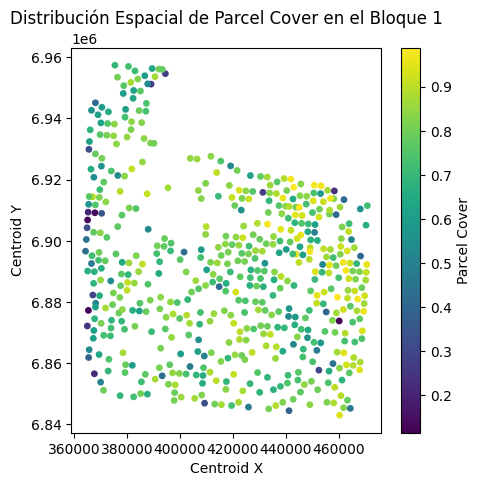

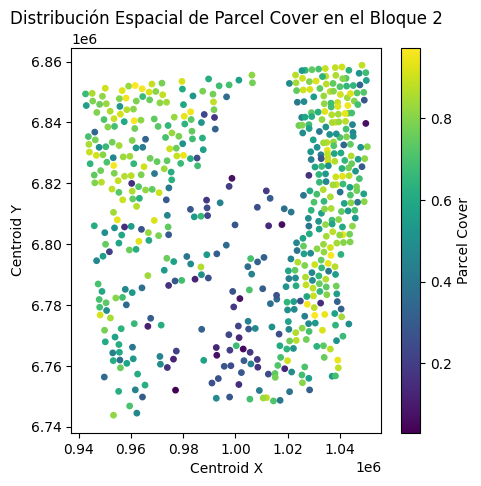

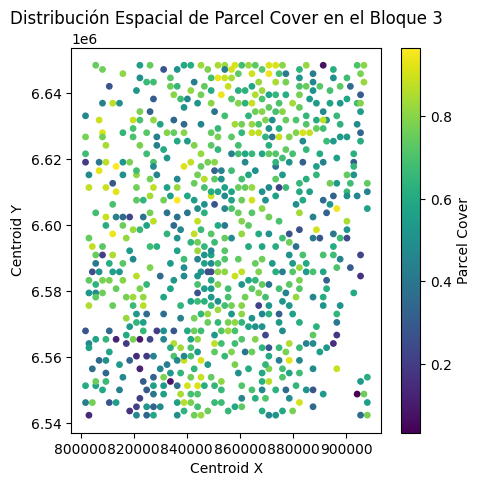

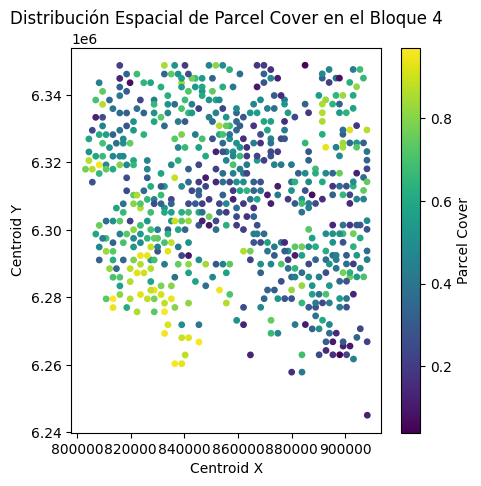

In [34]:
# Verificación visual
for block in sorted(metadata_df['Block'].unique()):
    if block == 0:
        continue  
    
    df_block = metadata_df[metadata_df['Block'] == block]
    
    plt.figure(figsize=(5,5))
    plt.scatter(df_block['centroid_x'], df_block['centroid_y'], 
                c=df_block['Parcel_Cover'], cmap='viridis', s=15)
    plt.colorbar(label='Parcel Cover')
    plt.xlabel('Centroid X')
    plt.ylabel('Centroid Y')
    plt.title(f'Distribución Espacial de Parcel Cover en el Bloque {block}')
    plt.show()


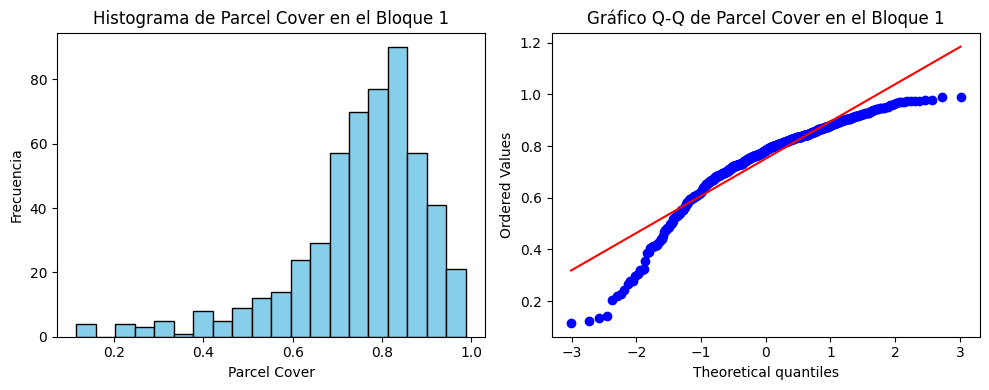

Bloque 1 - Estadístico de Shapiro-Wilk: 0.8899, p-valor: 0.0000
El p-valor es menor a 0.05, lo que indica que Parcel Cover en el bloque 1 no sigue una distribución normal.



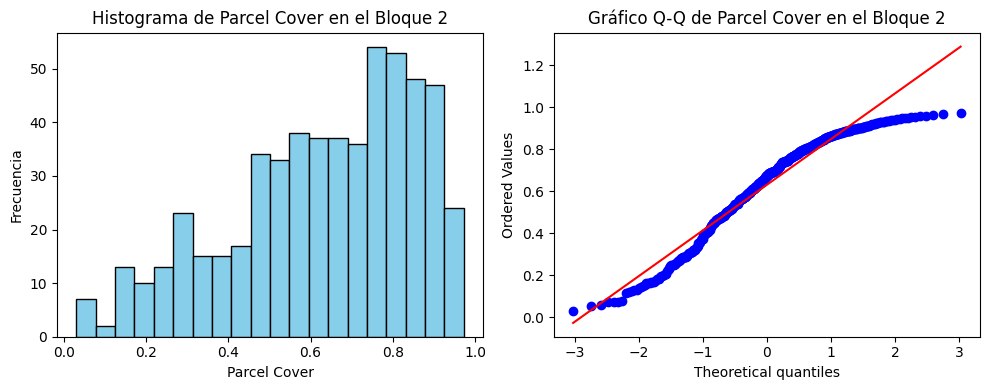

Bloque 2 - Estadístico de Shapiro-Wilk: 0.9469, p-valor: 0.0000
El p-valor es menor a 0.05, lo que indica que Parcel Cover en el bloque 2 no sigue una distribución normal.



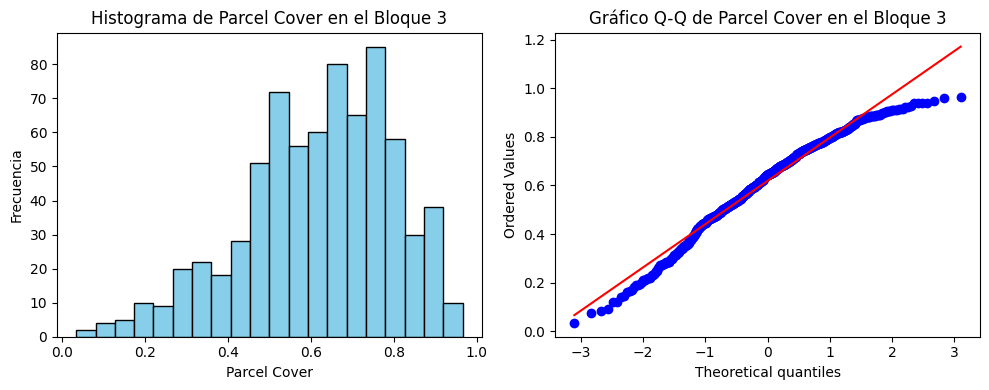

Bloque 3 - Estadístico de Shapiro-Wilk: 0.9749, p-valor: 0.0000
El p-valor es menor a 0.05, lo que indica que Parcel Cover en el bloque 3 no sigue una distribución normal.



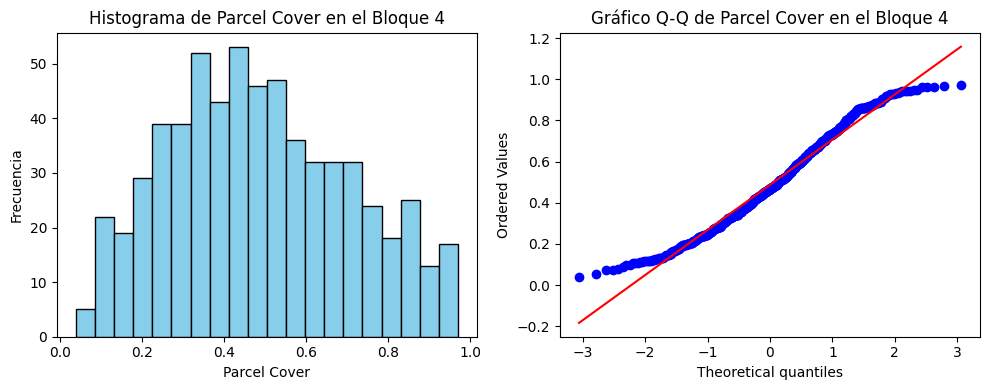

Bloque 4 - Estadístico de Shapiro-Wilk: 0.9776, p-valor: 0.0000
El p-valor es menor a 0.05, lo que indica que Parcel Cover en el bloque 4 no sigue una distribución normal.



In [26]:
# Evaluación de normalidad de Parcel_Cover en cada bloque
for block in sorted(metadata_df['Block'].unique()):
    if block == 0:
        continue  
        
    df_block = metadata_df[metadata_df['Block'] == block]
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df_block['Parcel_Cover'], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histograma de Parcel Cover en el Bloque {block}')
    plt.xlabel('Parcel Cover')
    plt.ylabel('Frecuencia')
    
    # Gráfico Q-Q 
    plt.subplot(1, 2, 2)
    stats.probplot(df_block['Parcel_Cover'], dist="norm", plot=plt)
    plt.title(f'Gráfico Q-Q de Parcel Cover en el Bloque {block}')
    plt.tight_layout()
    plt.show()
    
    # Shapiro-Wilk
    shapiro_test = stats.shapiro(df_block['Parcel_Cover'])
    print(f"Bloque {block} - Estadístico de Shapiro-Wilk: {shapiro_test.statistic:.4f}, p-valor: {shapiro_test.pvalue:.4f}")
    
    # Interpretación del p-valor
    if shapiro_test.pvalue < 0.05:
        print(f"El p-valor es menor a 0.05, lo que indica que Parcel Cover en el bloque {block} no sigue una distribución normal.\n")
    else:
        print(f"El p-valor es mayor a 0.05, lo que sugiere que Parcel Cover en el bloque {block} podría seguir una distribución normal.\n")


## Paso 2: Semivariograma experimental


Calculando el semivariograma para el Bloque 1


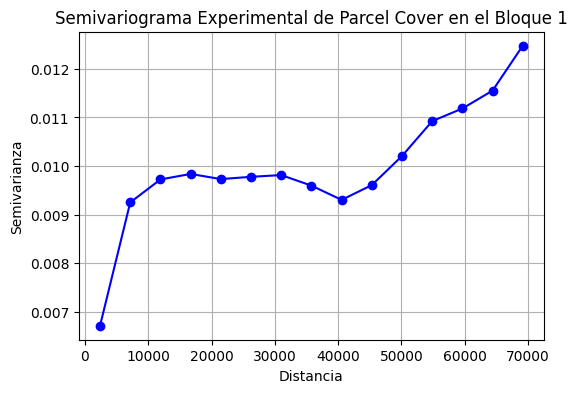


Calculando el semivariograma para el Bloque 2


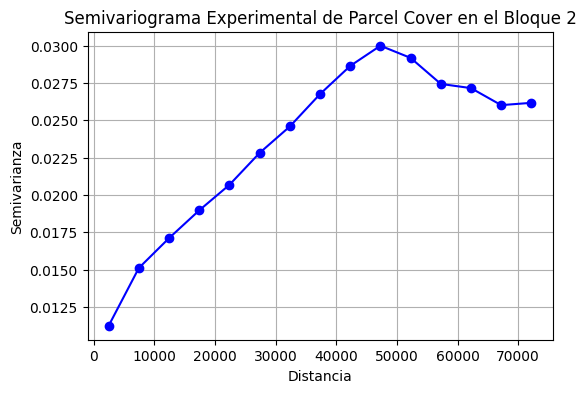


Calculando el semivariograma para el Bloque 3


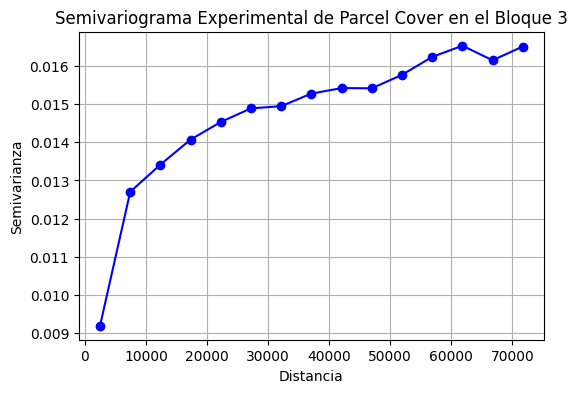


Calculando el semivariograma para el Bloque 4


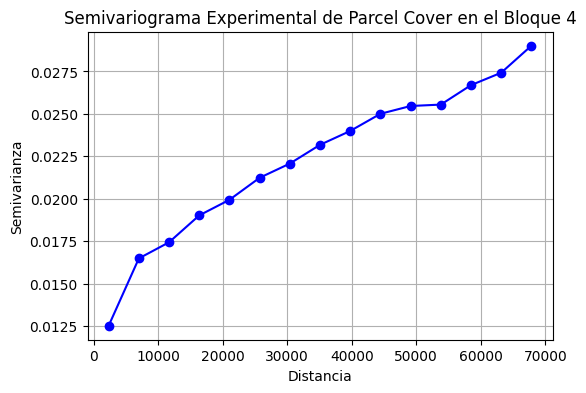

In [27]:
for block in sorted(metadata_df['Block'].unique()):
    if block == 0:
        continue 
    
    # Filtro del df paraobtener los datos del bloque actual
    df_block = metadata_df[metadata_df['Block'] == block]
    print(f"\nCalculando el semivariograma para el Bloque {block}")

    # Paso 1: Calcular las distancias entre pares de puntos
    coordinates = df_block[['centroid_x', 'centroid_y']].values # coordenadas espaciales de cada punto en el bloque
    distances = squareform(pdist(coordinates))  # Matriz de distancias entre pares - equivalente a lo que en R hacía dist()

    # Paso 2: Calcular la semivarianza para Parcel_Cover
    parcel_cover_values = df_block['Parcel_Cover'].values
    n = len(parcel_cover_values)
    semivariance = np.zeros_like(distances)

    # Calcular la semivarianza entre pares de puntos - Replica la lógica de variog de geoR en R
    for i in range(n):
        for j in range(i + 1, n):
            semivariance[i, j] = 0.5 * (parcel_cover_values[i] - parcel_cover_values[j]) ** 2

    # Paso 3: Agrupar por intervalos de distancia para construir el semivariograma
    max_distance = distances.max() / 2  # Tomar la mitad del máximo para limitar el rango de análisis, esto para reducir ruido y capturar cambios significativos iniciales.
    num_bins = 15 #Numero de intervalos de distancia
    bins = np.linspace(0, max_distance, num_bins + 1) 
    bin_centers = 0.5 * (bins[:-1] + bins[1:]) # Punto medio de cada intervalo
    semivariance_values = np.zeros(num_bins)

    # Promediar la semivarianza para cada intervalo de distancia
    for k in range(num_bins):
        mask = (distances >= bins[k]) & (distances < bins[k + 1])
        if np.any(mask):
            semivariance_values[k] = semivariance[mask].mean()

            
    plt.figure(figsize=(6, 4))
    plt.plot(bin_centers, semivariance_values, 'o-', color='blue')
    plt.xlabel('Distancia')
    plt.ylabel('Semivarianza')
    plt.title(f'Semivariograma Experimental de Parcel Cover en el Bloque {block}')
    plt.grid()
    plt.show()

## Paso 3: Ajuste de modelos teóricos


Ajustando modelos OLS para el Bloque 1...
Spherical - Nugget: 0.0080, Sill: 0.0111, Range: 69184.0550
Exponential - Nugget: 0.0079, Sill: 0.0134, Range: 69184.0550
Gaussian - Nugget: 0.0087, Sill: 0.0135, Range: 69184.0550
Matern - Nugget: 0.0102, Sill: 0.0134, Range: 69184.0550, Nu: 1.1655


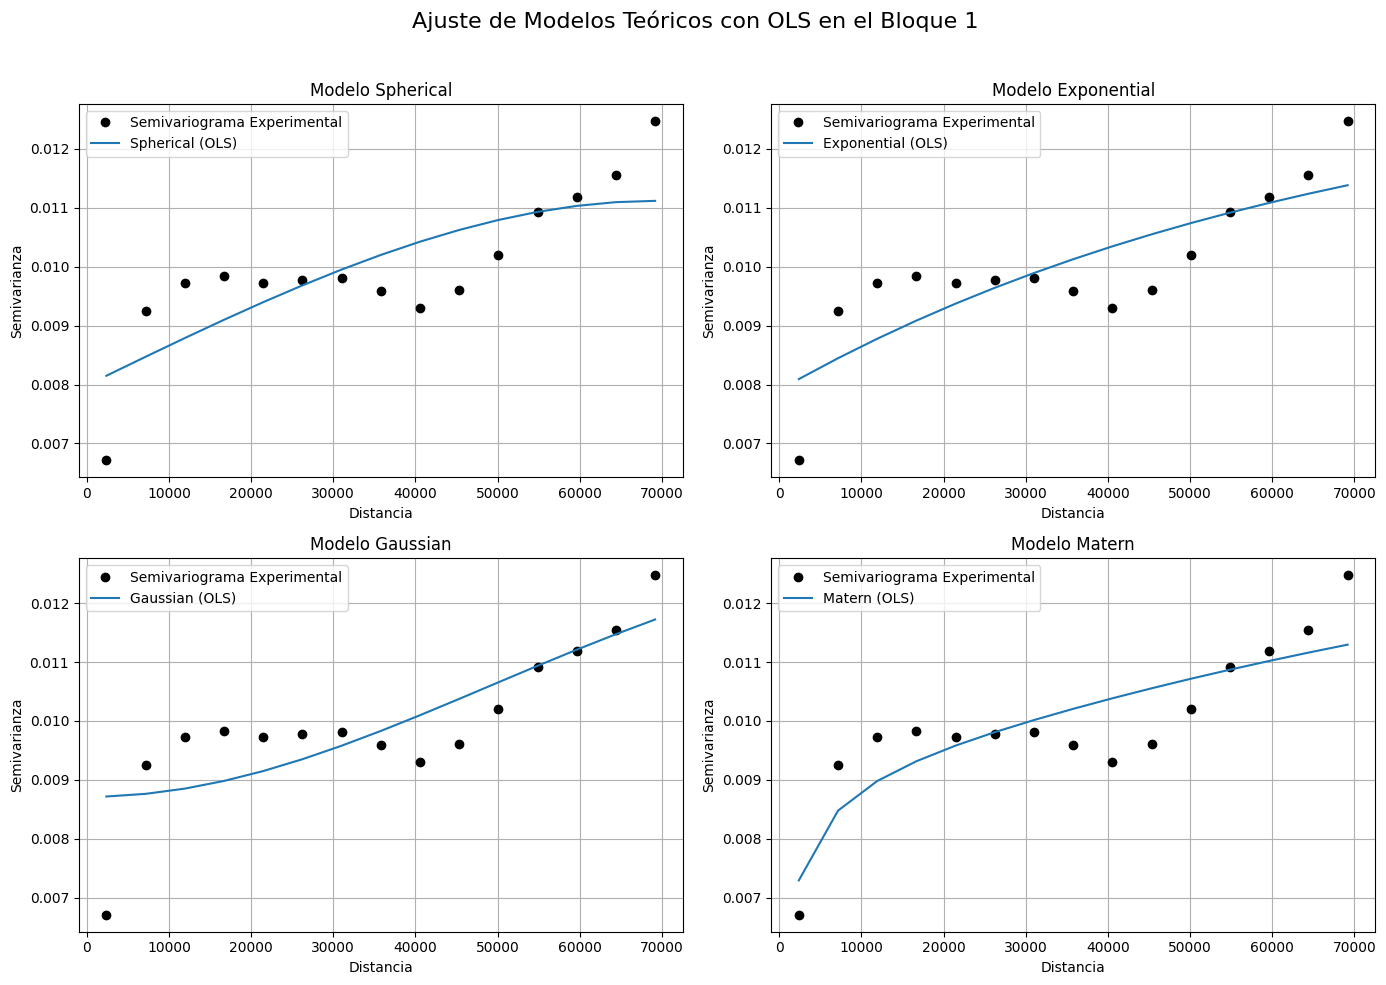


Ajustando modelos OLS para el Bloque 2...
Spherical - Nugget: 0.0103, Sill: 0.0278, Range: 48951.6746
Exponential - Nugget: 0.0082, Sill: 0.0288, Range: 19808.4550
Gaussian - Nugget: 0.0125, Sill: 0.0278, Range: 23779.8068
Matern - Nugget: 0.0124, Sill: 0.0283, Range: 14431.9580, Nu: 1.0603


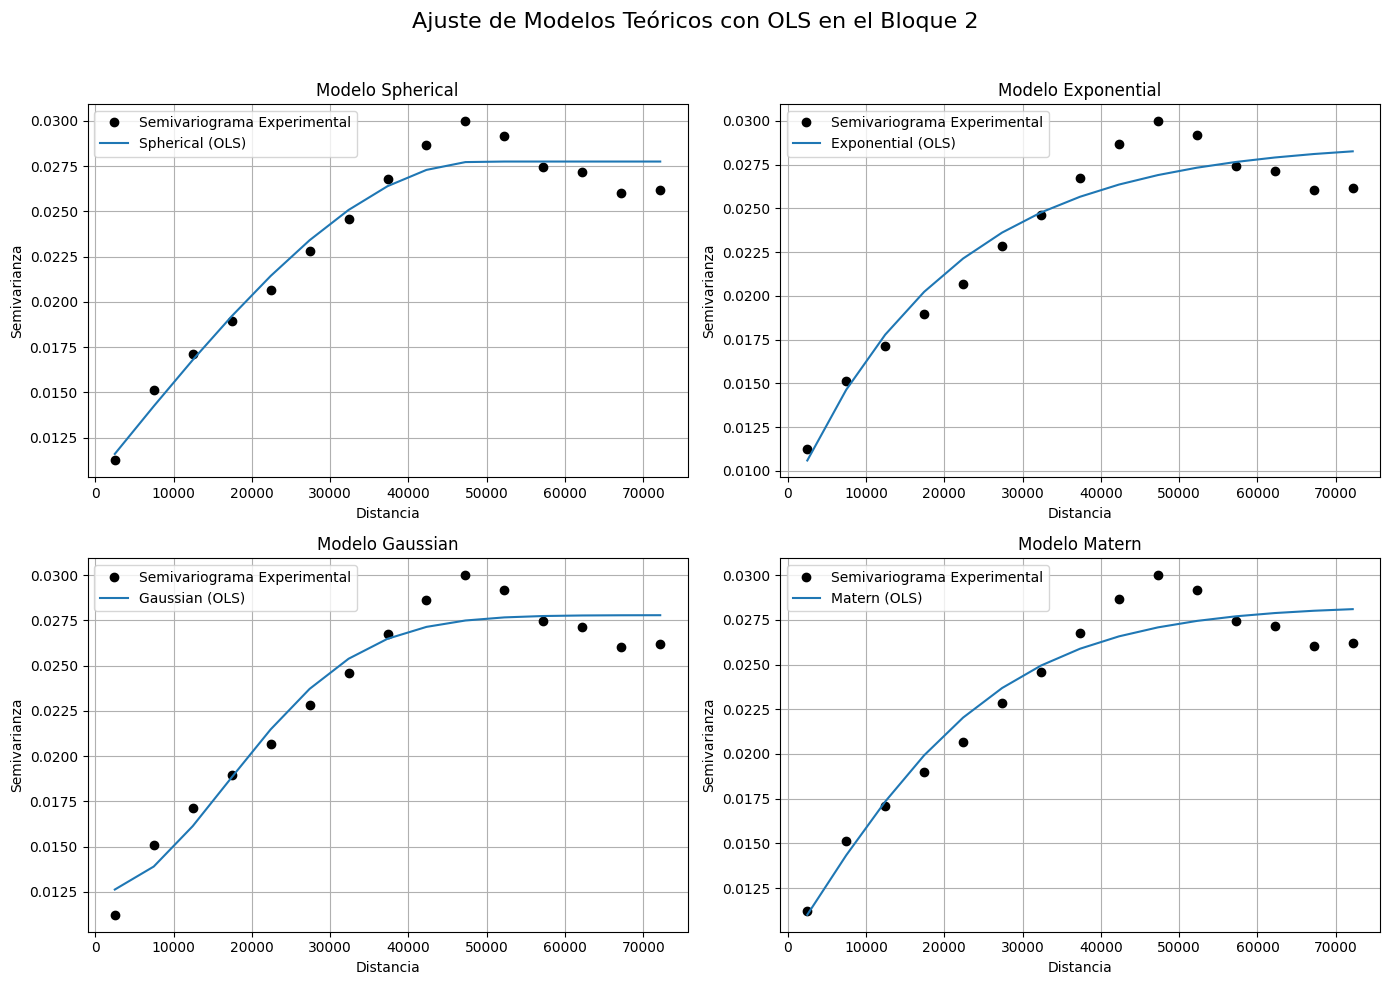


Ajustando modelos OLS para el Bloque 3...
Spherical - Nugget: 0.0094, Sill: 0.0157, Range: 31561.7110
Exponential - Nugget: 0.0114, Sill: 0.0203, Range: 71688.8033
Gaussian - Nugget: 0.0100, Sill: 0.0157, Range: 13719.2698
Matern - Nugget: 0.0154, Sill: 0.0174, Range: 55245.6792, Nu: 1.3348


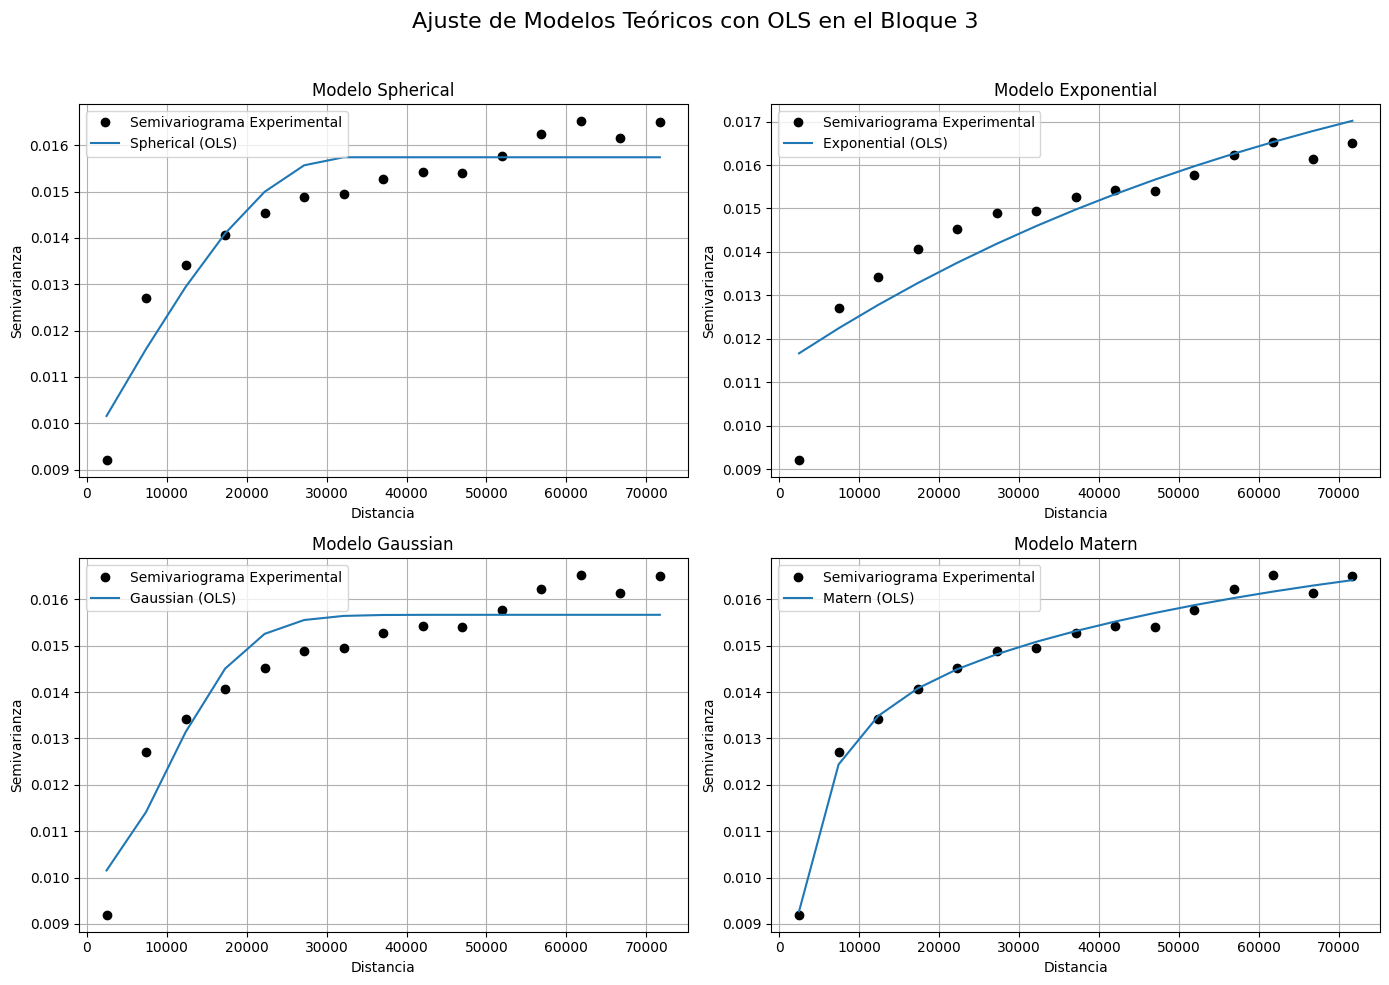


Ajustando modelos OLS para el Bloque 4...
Spherical - Nugget: 0.0134, Sill: 0.0274, Range: 67828.9042
Exponential - Nugget: 0.0127, Sill: 0.0325, Range: 45921.2052
Gaussian - Nugget: 0.0152, Sill: 0.0275, Range: 33345.6954
Matern - Nugget: 0.0000, Sill: 0.0301, Range: 11304.1044, Nu: 0.6351


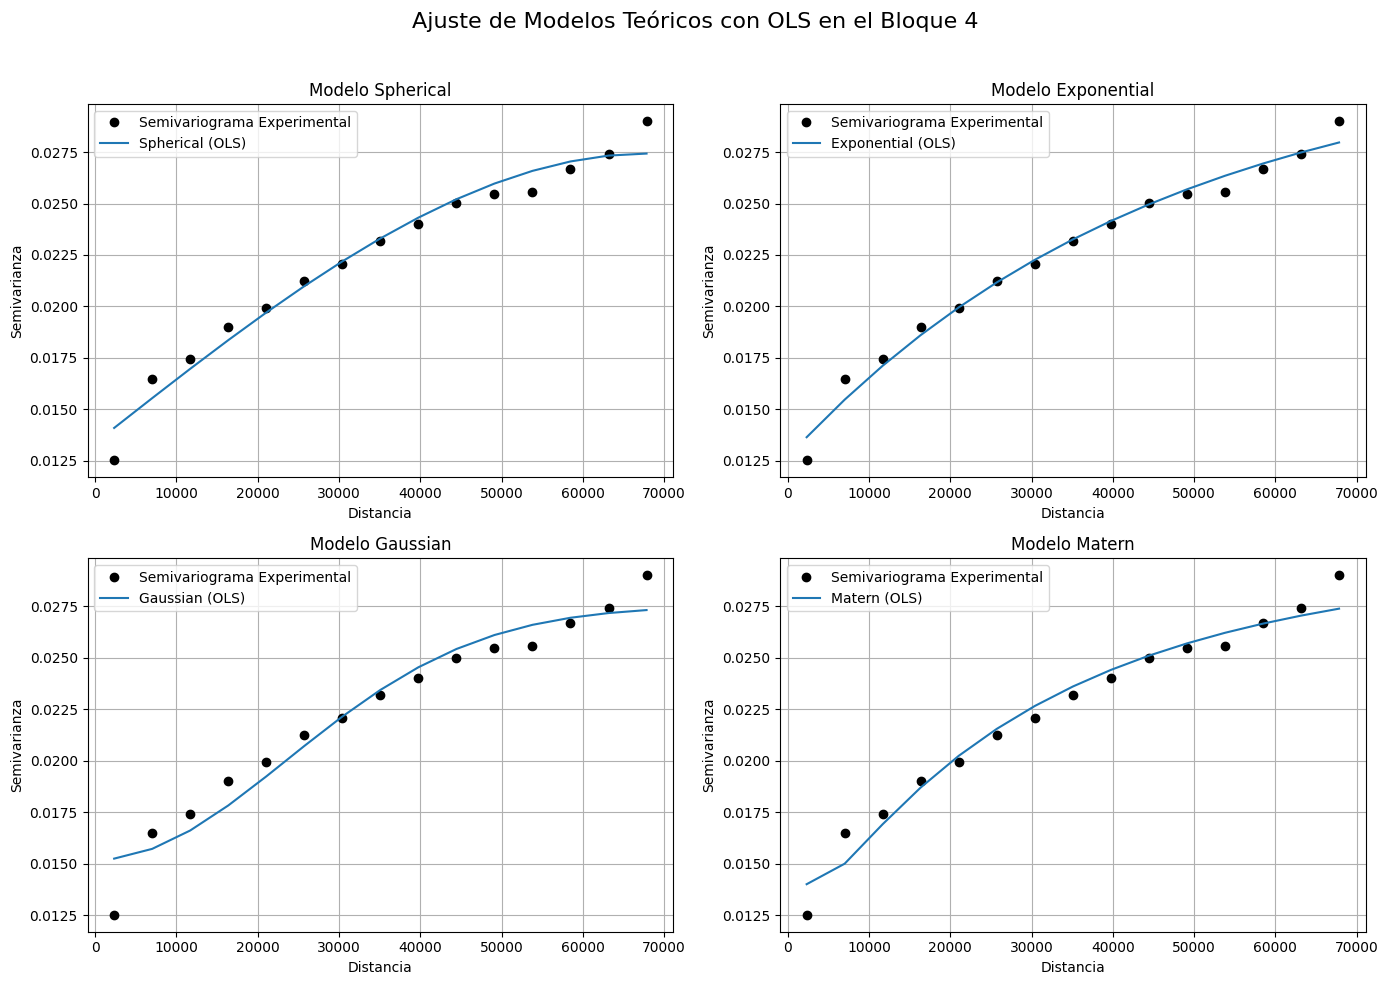

In [28]:
# OLS

# Definir funciones para los modelos teóricos de semivariograma
def spherical_model(h, nugget, sill, range_):
    return np.where(h < range_, nugget + (sill - nugget) * (1.5 * (h / range_) - 0.5 * (h / range_)**3), sill)

def exponential_model(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1 - np.exp(-h / range_))

def gaussian_model(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1 - np.exp(-(h / range_)**2))

def matern_model(h, nugget, sill, range_, nu):
    from scipy.special import kv, gamma
    factor = (2 ** (1 - nu)) / gamma(nu)
    component = (h / range_) ** nu
    return np.where(h == 0, nugget, nugget + (sill - nugget) * (1 - factor * component * kv(nu, component)))

# Función para calcular el semivariograma experimental
def calculate_distances_and_semivariogram(df_block, num_bins=15):
    coordinates = df_block[['centroid_x', 'centroid_y']].values
    distances = squareform(pdist(coordinates))
    parcel_cover_values = df_block['Parcel_Cover'].values
    n = len(parcel_cover_values)
    semivariance = np.zeros_like(distances)

    for i in range(n):
        for j in range(i + 1, n):
            semivariance[i, j] = 0.5 * (parcel_cover_values[i] - parcel_cover_values[j]) ** 2

    max_distance = distances.max() / 2
    bins = np.linspace(0, max_distance, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    semivariance_values = np.zeros(num_bins)

    for k in range(num_bins):
        mask = (distances >= bins[k]) & (distances < bins[k + 1])
        if np.any(mask):
            semivariance_values[k] = semivariance[mask].mean()

    return bin_centers, semivariance_values

# Ajustar los modelos teóricos usando OLS
def fit_model_ols(model_func, bin_centers, semivariance_values):
    if model_func == matern_model:
        initial_params = [0.01, 0.03, max(bin_centers), 0.5]
        bounds = (0, [1, 1, max(bin_centers), 5])
    else:
        initial_params = [0.01, 0.03, max(bin_centers)]
        bounds = (0, [1, 1, max(bin_centers)])
        
    """
    Se usaron estos valores iniciales para reflejar tendencias observadas 
    en los semivariogramas experimentalwa en general: un nugget bajo sugiere 
    variabilidad mínima a corta distancia, mientras que el range_ y el sill 
    se ajustan para abarcar el rango de distancias y la estabilidad observada. 
    """
    
    params, _ = curve_fit(model_func, bin_centers, semivariance_values, 
                          p0=initial_params, bounds=bounds)
    return params

# Visualización del ajuste de cada modelo con OLS
def plot_fitted_models_ols(bin_centers, semivariance_values, models, block):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Ajuste de Modelos Teóricos con OLS en el Bloque {block}', fontsize=16)

    for ax, (model_name, model_func) in zip(axs.ravel(), models.items()):
        params_ols = fit_model_ols(model_func, bin_centers, semivariance_values)
        
        ax.plot(bin_centers, semivariance_values, 'o', color='black', label='Semivariograma Experimental')
        ax.plot(bin_centers, model_func(bin_centers, *params_ols), '-', label=f'{model_name} (OLS)')
        
        ax.set_title(f'Modelo {model_name}')
        ax.set_xlabel('Distancia')
        ax.set_ylabel('Semivarianza')
        ax.legend()
        ax.grid()
        
        if model_name == 'Matern':
            print(f"{model_name} - Nugget: {params_ols[0]:.4f}, Sill: {params_ols[1]:.4f}, "
                  f"Range: {params_ols[2]:.4f}, Nu: {params_ols[3]:.4f}")
        else:
            print(f"{model_name} - Nugget: {params_ols[0]:.4f}, Sill: {params_ols[1]:.4f}, "
                  f"Range: {params_ols[2]:.4f}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Ejecución para cada bloque
for block in sorted(metadata_df['Block'].unique()):
    if block == 0:
        continue

    df_block = metadata_df[metadata_df['Block'] == block]
    bin_centers, semivariance_values = calculate_distances_and_semivariogram(df_block)
    
    print(f"\nAjustando modelos OLS para el Bloque {block}...")

    models = {
        'Spherical': spherical_model,
        'Exponential': exponential_model,
        'Gaussian': gaussian_model,
        'Matern': matern_model
    }

    plot_fitted_models_ols(bin_centers, semivariance_values, models, block)


Ajustando modelos ML para el Bloque 1...
Spherical (ML) - Nugget: 0.0080, Sill: 0.0111, Range: 69184.0550
Exponential (ML) - Nugget: 0.0079, Sill: 0.0134, Range: 69184.0550
Gaussian (ML) - Nugget: 0.0087, Sill: 0.0135, Range: 69184.0550
Matern (ML) - Nugget: 0.0046, Sill: 0.0136, Range: 69184.0550, Nu: 0.5029


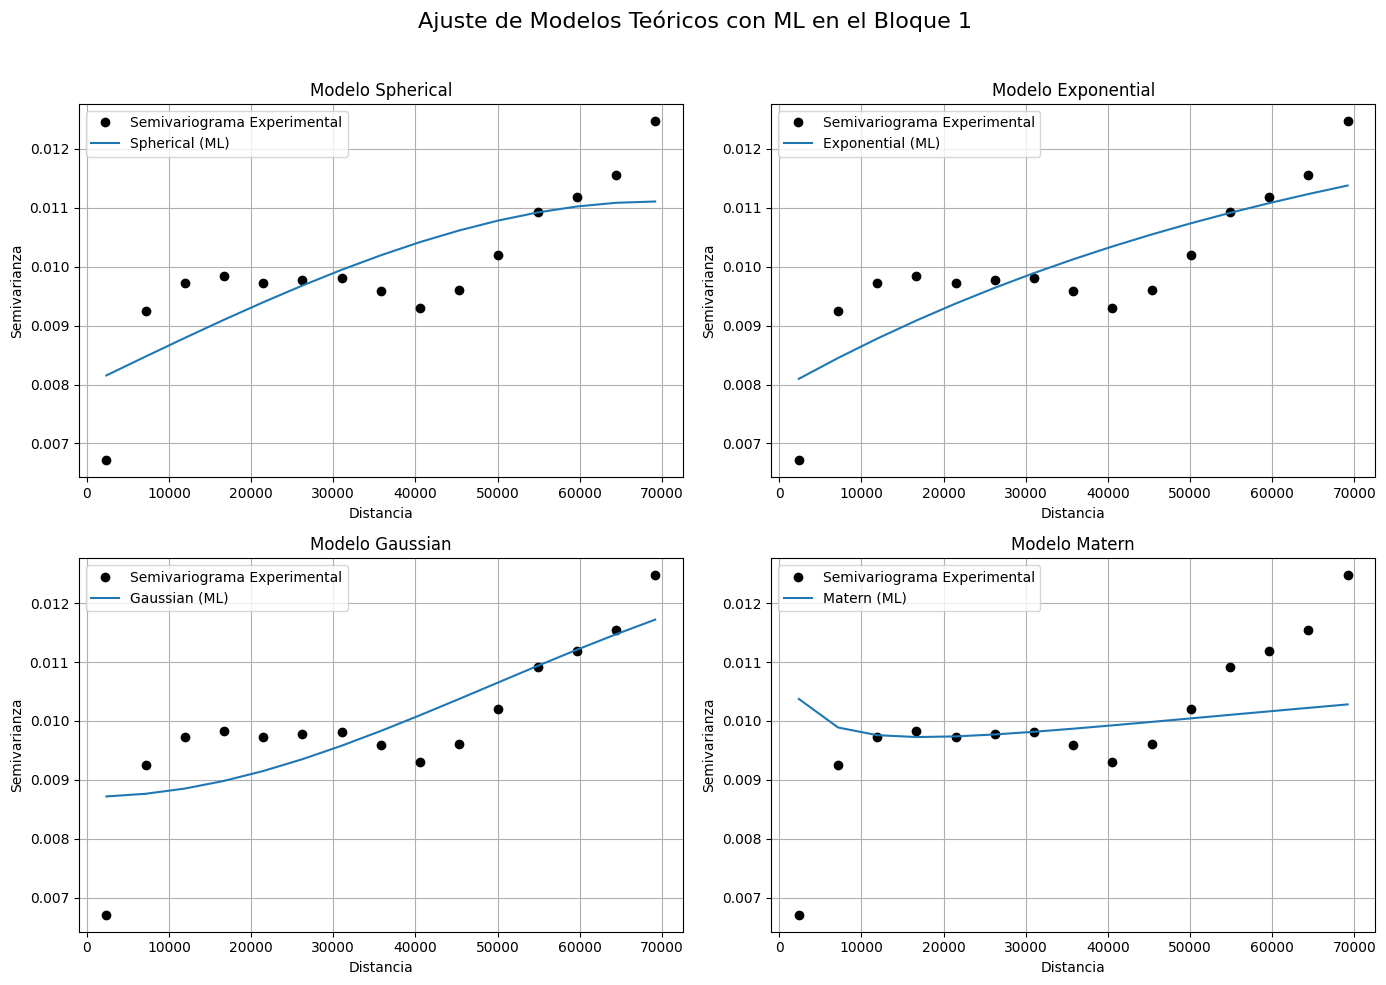


Ajustando modelos ML para el Bloque 2...
Spherical (ML) - Nugget: 0.0130, Sill: 0.0294, Range: 72168.2321
Exponential (ML) - Nugget: 0.0134, Sill: 0.0401, Range: 72168.2321
Gaussian (ML) - Nugget: 0.0181, Sill: 0.0382, Range: 72168.2321
Matern (ML) - Nugget: 0.0000, Sill: 0.0314, Range: 72168.2321, Nu: 0.3001


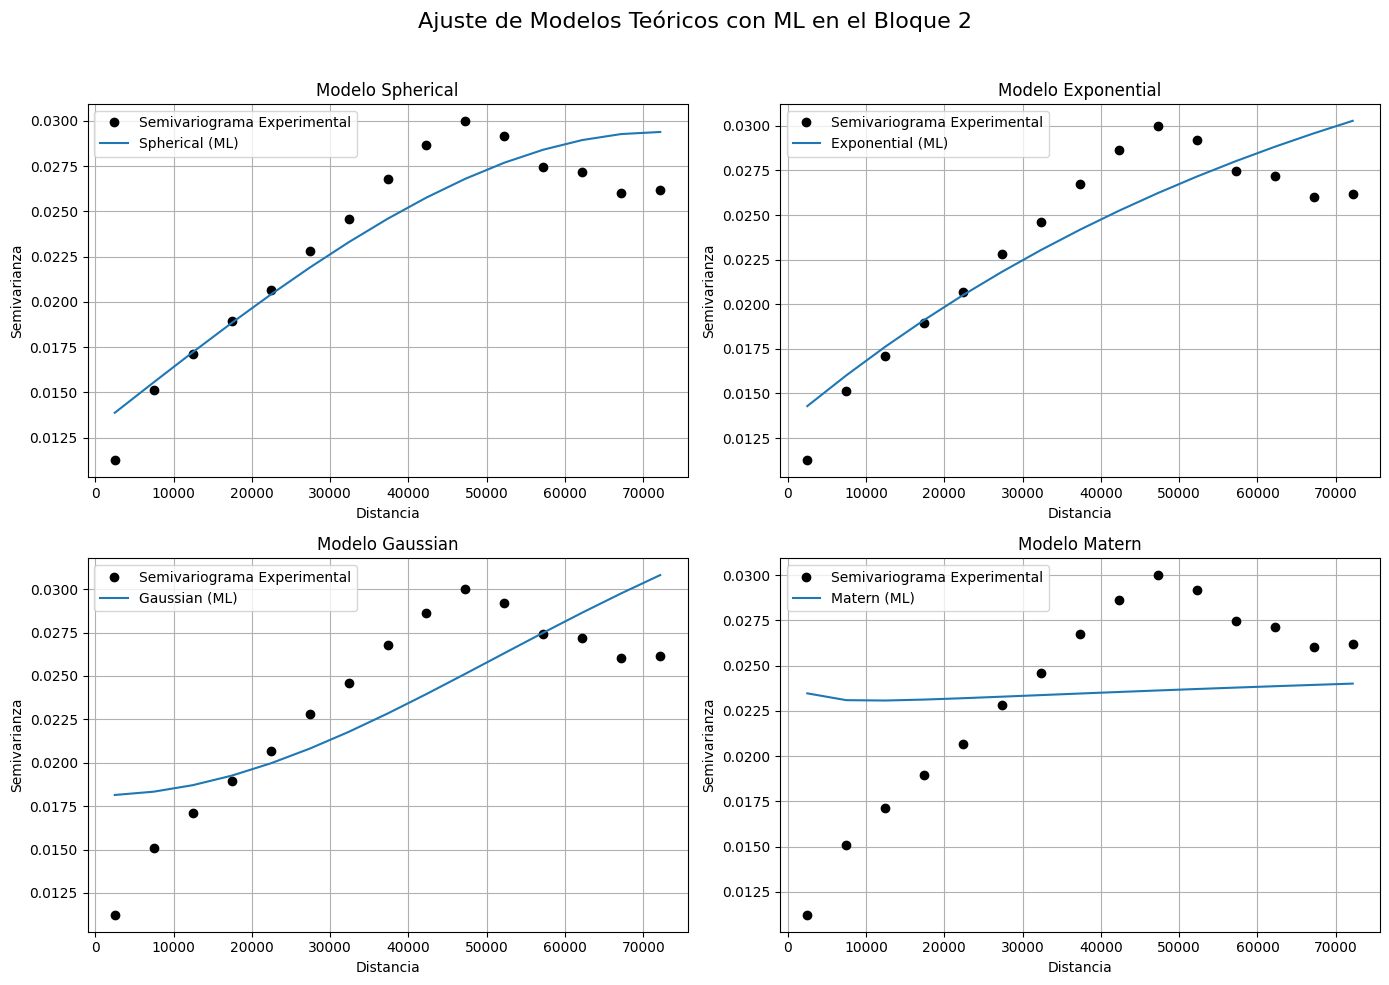


Ajustando modelos ML para el Bloque 3...
Spherical (ML) - Nugget: 0.0113, Sill: 0.0167, Range: 71688.8034
Exponential (ML) - Nugget: 0.0114, Sill: 0.0203, Range: 71688.8034
Gaussian (ML) - Nugget: 0.0129, Sill: 0.0197, Range: 71688.8034
Matern (ML) - Nugget: 0.0163, Sill: 0.0137, Range: 71688.8034, Nu: 0.5007


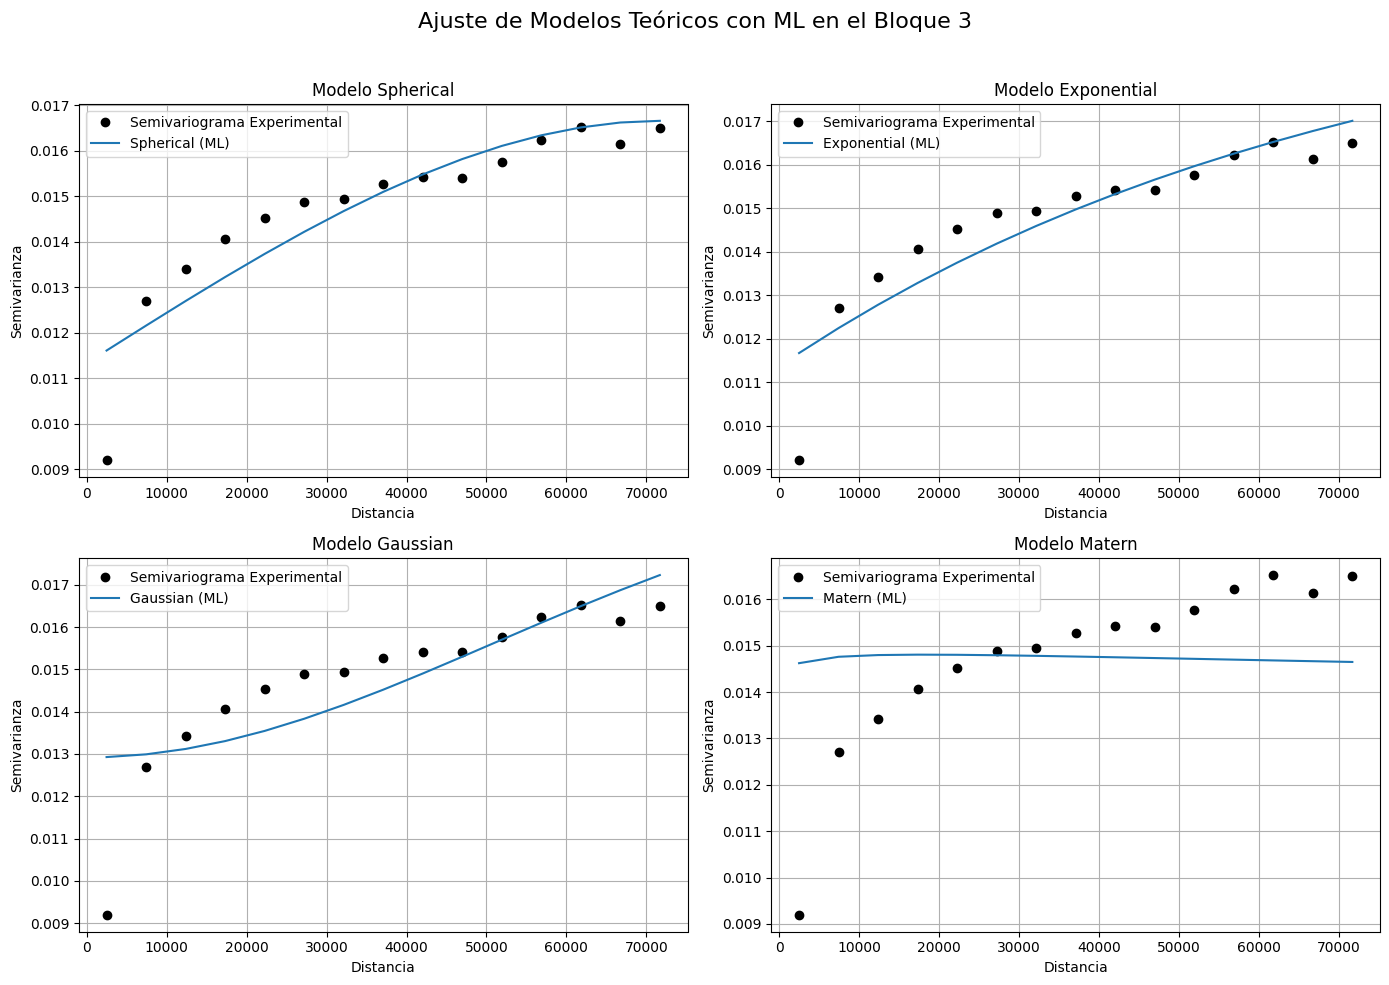


Ajustando modelos ML para el Bloque 4...
Spherical (ML) - Nugget: 0.0134, Sill: 0.0274, Range: 67828.9042
Exponential (ML) - Nugget: 0.0134, Sill: 0.0372, Range: 67828.9042
Gaussian (ML) - Nugget: 0.0171, Sill: 0.0369, Range: 67828.9042
Matern (ML) - Nugget: 0.0066, Sill: 0.0330, Range: 67828.9042, Nu: 0.4998


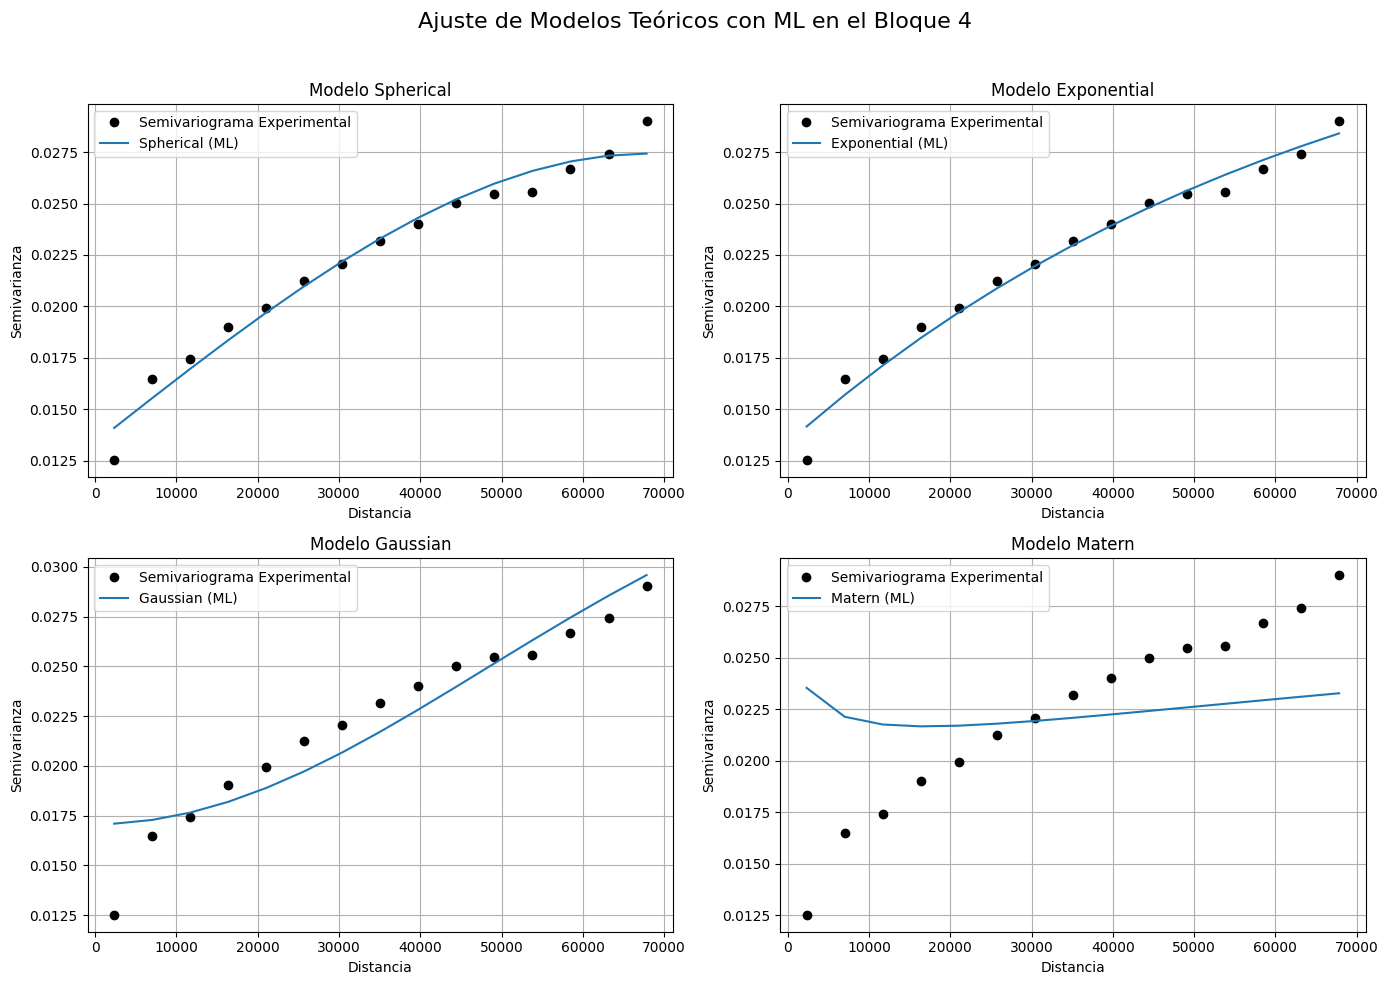

In [29]:
# Maxima verosimilitid - ML

# Definir funciones para los modelos de semivariograma
def spherical_model(h, nugget, sill, range_):
    return np.where(h < range_, nugget + (sill - nugget) * (1.5 * (h / range_) - 0.5 * (h / range_)**3), sill)

def exponential_model(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1 - np.exp(-h / range_))

def gaussian_model(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1 - np.exp(-(h / range_)**2))

def matern_model(h, nugget, sill, range_, nu):
    factor = (2 ** (1 - nu)) / gamma(nu)
    component = (h / range_) ** nu
    return np.where(h == 0, nugget, nugget + (sill - nugget) * (1 - factor * component * kv(nu, component)))

# Calcular distancias y semivariograma experimental
def calculate_distances_and_semivariogram(df_block, num_bins=15):
    coordinates = df_block[['centroid_x', 'centroid_y']].values
    distances = squareform(pdist(coordinates))
    parcel_cover_values = df_block['Parcel_Cover'].values
    n = len(parcel_cover_values)
    semivariance = np.zeros_like(distances)

    for i in range(n):
        for j in range(i + 1, n):
            semivariance[i, j] = 0.5 * (parcel_cover_values[i] - parcel_cover_values[j]) ** 2

    max_distance = distances.max() / 2
    bins = np.linspace(0, max_distance, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    semivariance_values = np.zeros(num_bins)

    for k in range(num_bins):
        mask = (distances >= bins[k]) & (distances < bins[k + 1])
        if np.any(mask):
            semivariance_values[k] = semivariance[mask].mean()

    return bin_centers, semivariance_values

# Función de verosimilitud negativa para ML
def negative_log_likelihood_ml(params, model_func, distances, semivariance_values):
    # Asigna parámetros según el modelo usado (el de Matérn necesita nu)
    if model_func == matern_model:
        nugget, sill, range_, nu = params
        model_values = model_func(distances, nugget, sill, range_, nu)
    else:
        nugget, sill, range_ = params
        model_values = model_func(distances, nugget, sill, range_)
    
    residuals = semivariance_values - model_values
    return np.sum(residuals ** 2) # Retorna el error cuadrático total como verosimilitud negativa

# Ajuste de modelos teóricos usando ML
def fit_model_ml(model_func, distances, semivariance_values):
    if model_func == matern_model:
        initial_params = [0.01, 0.03, max(distances), 0.5]
        bounds = [(0, 1), (0, 1), (0, max(distances)), (0.1, 5)]
    else:
        initial_params = [0.01, 0.03, max(distances)]
        bounds = [(0, 1), (0, 1), (0, max(distances))]
    
    result = minimize(negative_log_likelihood_ml, initial_params, args=(model_func, distances, semivariance_values), 
                      bounds=bounds, method='L-BFGS-B')
    return result.x

# Visualización del ajuste con ML
def plot_fitted_models_ml(distances, semivariance_values, models, block):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Ajuste de Modelos Teóricos con ML en el Bloque {block}', fontsize=16)

    for ax, (model_name, model_func) in zip(axs.ravel(), models.items()):
        params_ml = fit_model_ml(model_func, distances, semivariance_values)
        
        ax.plot(distances, semivariance_values, 'o', color='black', label='Semivariograma Experimental')
        ax.plot(distances, model_func(distances, *params_ml), '-', label=f'{model_name} (ML)')
        
        ax.set_title(f'Modelo {model_name}')
        ax.set_xlabel('Distancia')
        ax.set_ylabel('Semivarianza')
        ax.legend()
        ax.grid()
        
        if model_name == 'Matern':
            print(f"{model_name} (ML) - Nugget: {params_ml[0]:.4f}, Sill: {params_ml[1]:.4f}, Range: {params_ml[2]:.4f}, Nu: {params_ml[3]:.4f}")
        else:
            print(f"{model_name} (ML) - Nugget: {params_ml[0]:.4f}, Sill: {params_ml[1]:.4f}, Range: {params_ml[2]:.4f}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Ejecución para cada bloque
for block in sorted(metadata_df['Block'].unique()):
    if block == 0:
        continue

    df_block = metadata_df[metadata_df['Block'] == block]
    bin_centers, semivariance_values = calculate_distances_and_semivariogram(df_block)
    
    print(f"\nAjustando modelos ML para el Bloque {block}...")

    models = {
        'Spherical': spherical_model,
        'Exponential': exponential_model,
        'Gaussian': gaussian_model,
        'Matern': matern_model
    }

    plot_fitted_models_ml(bin_centers, semivariance_values, models, block)


Ajustando modelos REML para el Bloque 1...
Spherical (REML) - Nugget: 0.0080, Sill: 0.0111, Range: 69184.0550
Exponential (REML) - Nugget: 0.0079, Sill: 0.0134, Range: 69184.0550
Gaussian (REML) - Nugget: 0.0087, Sill: 0.0135, Range: 69184.0550
Matern (REML) - Nugget: 0.0046, Sill: 0.0136, Range: 69184.0550, Nu: 0.5010


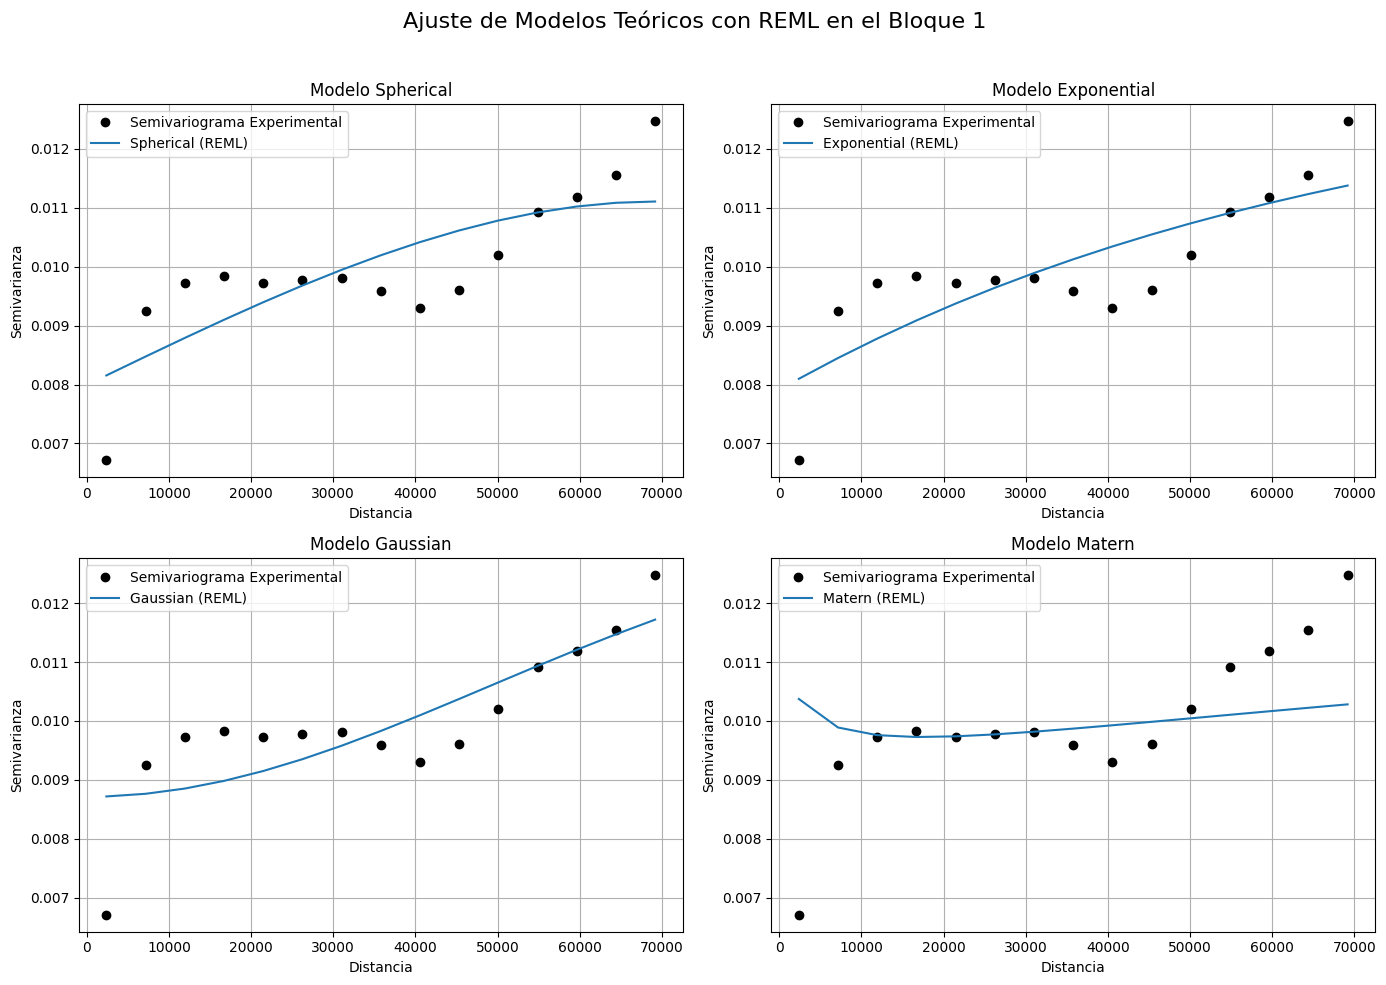


Ajustando modelos REML para el Bloque 2...
Spherical (REML) - Nugget: 0.0130, Sill: 0.0294, Range: 72168.2321
Exponential (REML) - Nugget: 0.0134, Sill: 0.0401, Range: 72168.2321
Gaussian (REML) - Nugget: 0.0181, Sill: 0.0382, Range: 72168.2321
Matern (REML) - Nugget: 0.0000, Sill: 0.0314, Range: 72168.2321, Nu: 0.3001


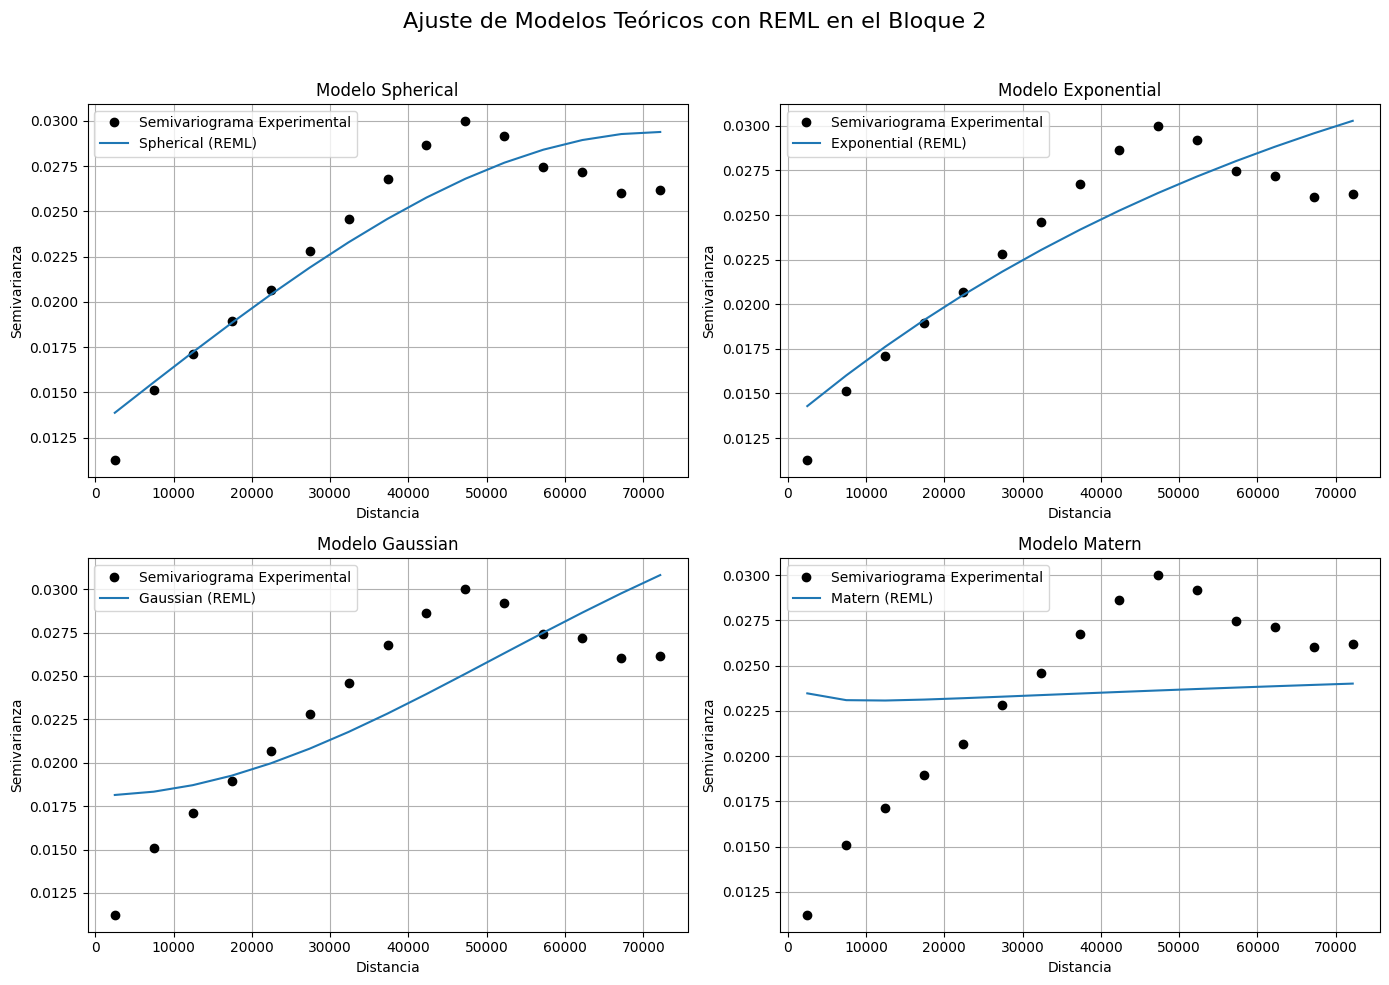


Ajustando modelos REML para el Bloque 3...
Spherical (REML) - Nugget: 0.0113, Sill: 0.0167, Range: 71688.8034
Exponential (REML) - Nugget: 0.0114, Sill: 0.0203, Range: 71688.8034
Gaussian (REML) - Nugget: 0.0129, Sill: 0.0197, Range: 71688.8034
Matern (REML) - Nugget: 0.0162, Sill: 0.0138, Range: 71688.8034, Nu: 0.4999


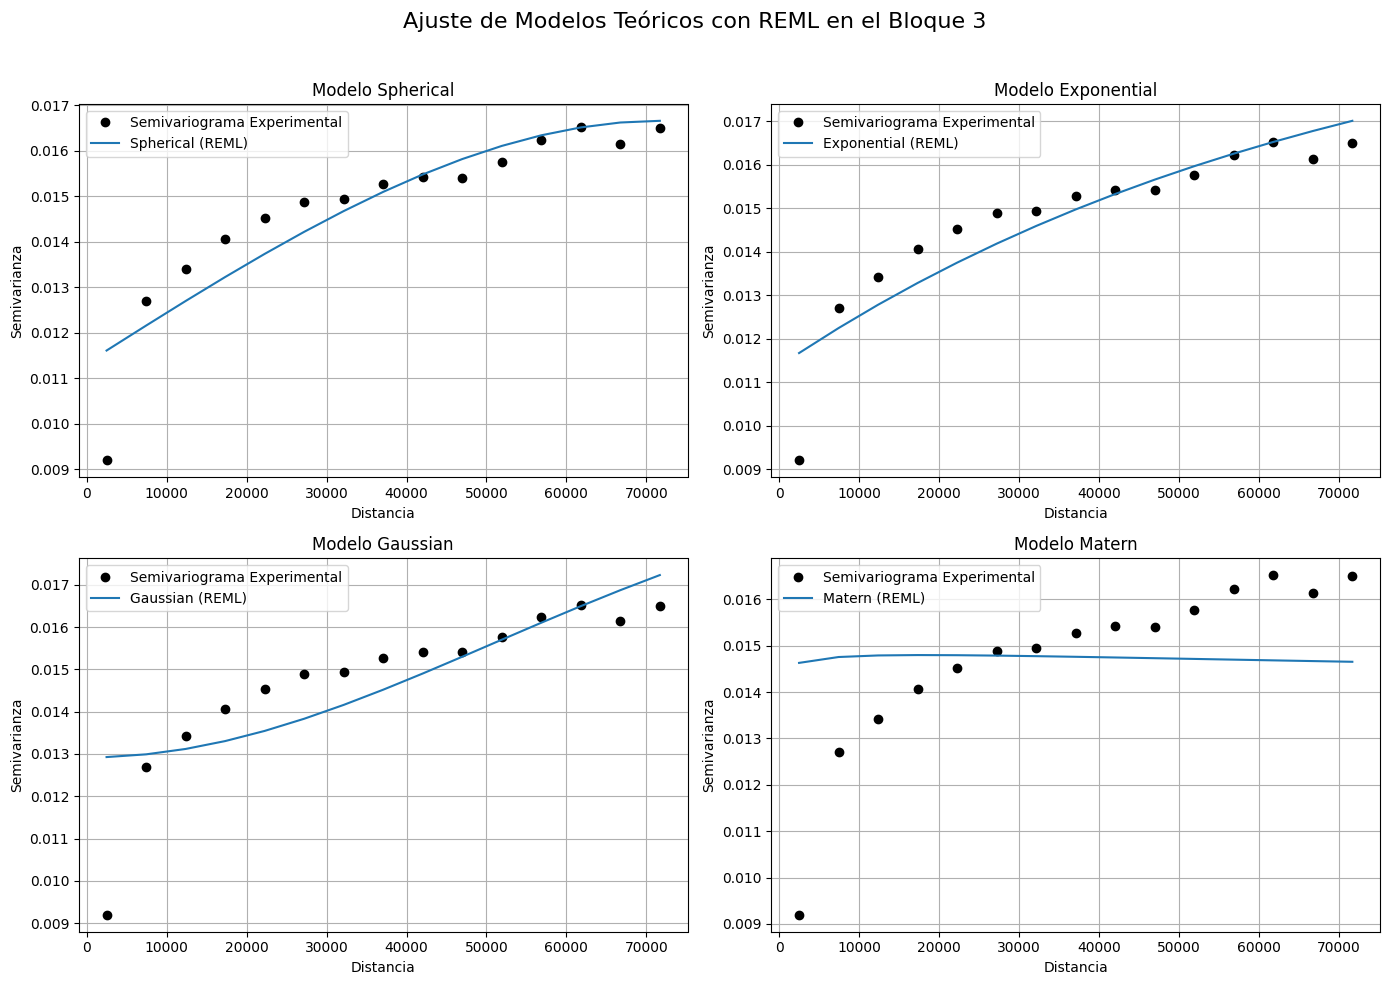


Ajustando modelos REML para el Bloque 4...
Spherical (REML) - Nugget: 0.0134, Sill: 0.0274, Range: 67828.9042
Exponential (REML) - Nugget: 0.0134, Sill: 0.0372, Range: 67828.9042
Gaussian (REML) - Nugget: 0.0171, Sill: 0.0369, Range: 67828.9042
Matern (REML) - Nugget: 0.0066, Sill: 0.0330, Range: 67828.9042, Nu: 0.4998


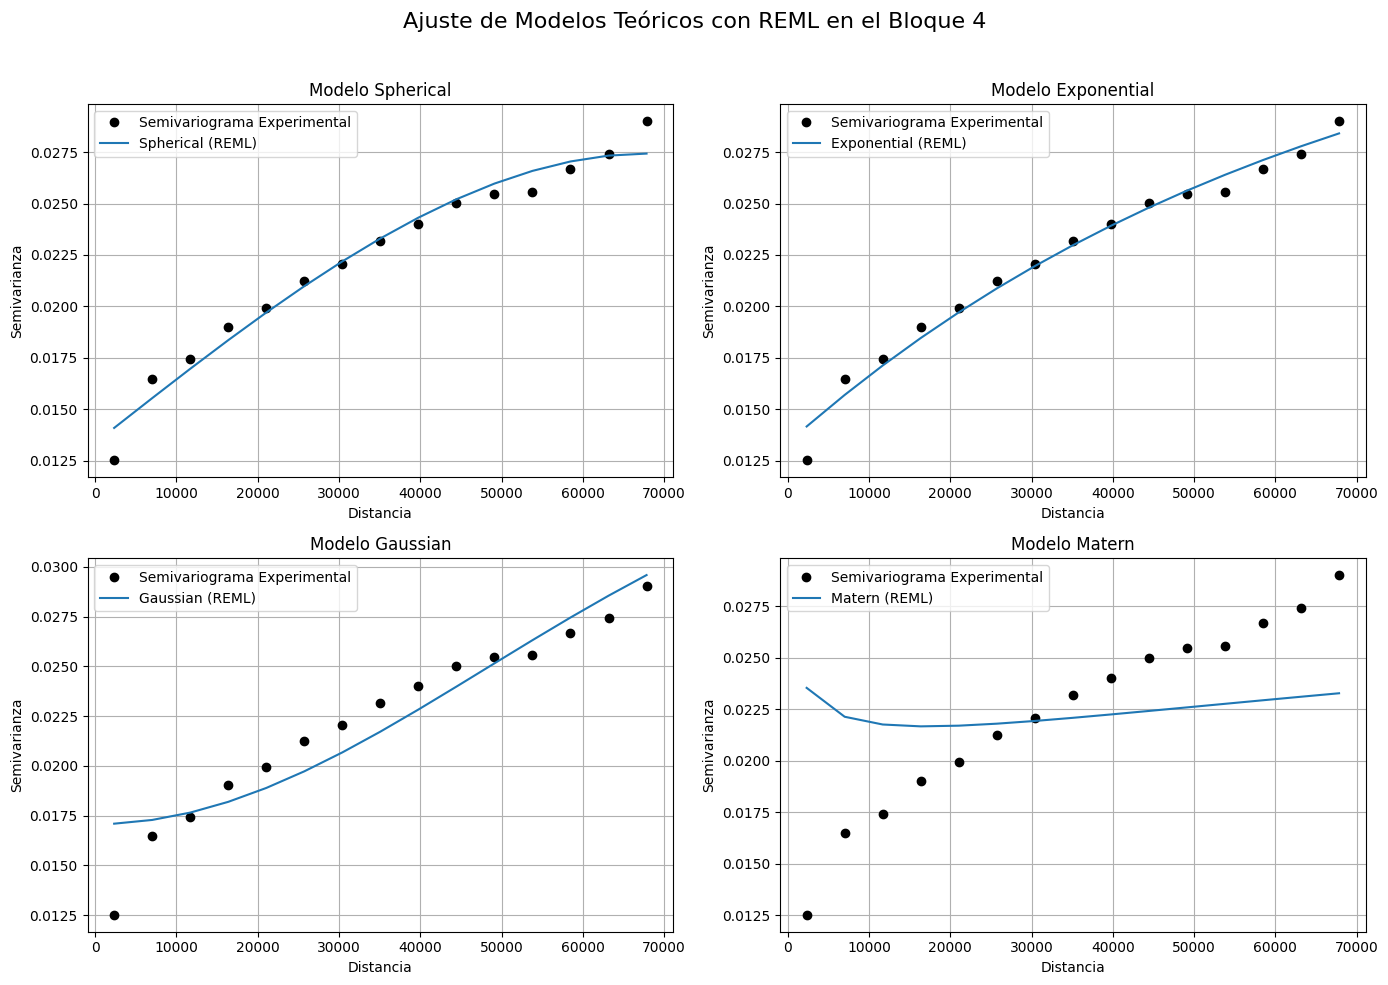

In [30]:
# Definir funciones para los modelos de semivariograma
def spherical_model(h, nugget, sill, range_):
    return np.where(h < range_, nugget + (sill - nugget) * (1.5 * (h / range_) - 0.5 * (h / range_)**3), sill)

def exponential_model(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1 - np.exp(-h / range_))

def gaussian_model(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1 - np.exp(-(h / range_)**2))

def matern_model(h, nugget, sill, range_, nu):
    factor = (2 ** (1 - nu)) / gamma(nu)
    component = (h / range_) ** nu
    return np.where(h == 0, nugget, nugget + (sill - nugget) * (1 - factor * component * kv(nu, component)))

# Calcular distancias y semivariograma experimental
def calculate_distances_and_semivariogram(df_block, num_bins=15):
    coordinates = df_block[['centroid_x', 'centroid_y']].values
    distances = squareform(pdist(coordinates))
    parcel_cover_values = df_block['Parcel_Cover'].values
    n = len(parcel_cover_values)
    semivariance = np.zeros_like(distances)

    for i in range(n):
        for j in range(i + 1, n):
            semivariance[i, j] = 0.5 * (parcel_cover_values[i] - parcel_cover_values[j]) ** 2

    max_distance = distances.max() / 2
    bins = np.linspace(0, max_distance, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    semivariance_values = np.zeros(num_bins)

    for k in range(num_bins):
        mask = (distances >= bins[k]) & (distances < bins[k + 1])
        if np.any(mask):
            semivariance_values[k] = semivariance[mask].mean()

    return bin_centers, semivariance_values

# Función de verosimilitud negativa para REML
def negative_log_likelihood_reml(params, model_func, distances, semivariance_values):
    if model_func == matern_model:
        nugget, sill, range_, nu = params
        model_values = model_func(distances, nugget, sill, range_, nu)
    else:
        nugget, sill, range_ = params
        model_values = model_func(distances, nugget, sill, range_)
    
    residuals = semivariance_values - model_values
    n = len(residuals) # Número de puntos de datos
    
    # Penalización de REML
    # Ajusta la verosimilitud para corregir por número de parámetros
    log_likelihood_adjustment = np.log(n / (n - len(params)))
    return np.sum(residuals ** 2) * log_likelihood_adjustment # Devuelve la verosimilitud negativa con ajuste REML, minimizando el error cuadrático
    """
    Esta parte ayuda a que el modelo ajuste la verosimilitud según el número de datos en 
    comparación con el número de parámetros. Evita que el modelo se sobreajuste a los datos.
    """

# Ajuste de modelos teóricos usando REML
def fit_model_reml(model_func, distances, semivariance_values):
    if model_func == matern_model:
        initial_params = [0.01, 0.03, max(distances), 0.5]
        bounds = [(0, 1), (0, 1), (0, max(distances)), (0.1, 5)]
    else:
        initial_params = [0.01, 0.03, max(distances)]
        bounds = [(0, 1), (0, 1), (0, max(distances))]
    
    result = minimize(negative_log_likelihood_reml, initial_params, args=(model_func, distances, semivariance_values), 
                      bounds=bounds, method='L-BFGS-B')
    return result.x

# Visualización del ajuste con REML
def plot_fitted_models_reml(distances, semivariance_values, models, block):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Ajuste de Modelos Teóricos con REML en el Bloque {block}', fontsize=16)

    for ax, (model_name, model_func) in zip(axs.ravel(), models.items()):
        params_reml = fit_model_reml(model_func, distances, semivariance_values)
        
        ax.plot(distances, semivariance_values, 'o', color='black', label='Semivariograma Experimental')
        ax.plot(distances, model_func(distances, *params_reml), '-', label=f'{model_name} (REML)')
        
        ax.set_title(f'Modelo {model_name}')
        ax.set_xlabel('Distancia')
        ax.set_ylabel('Semivarianza')
        ax.legend()
        ax.grid()
        
        if model_name == 'Matern':
            print(f"{model_name} (REML) - Nugget: {params_reml[0]:.4f}, Sill: {params_reml[1]:.4f}, Range: {params_reml[2]:.4f}, Nu: {params_reml[3]:.4f}")
        else:
            print(f"{model_name} (REML) - Nugget: {params_reml[0]:.4f}, Sill: {params_reml[1]:.4f}, Range: {params_reml[2]:.4f}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Ejecución para cada bloque
for block in sorted(metadata_df['Block'].unique()):
    if block == 0:
        continue

    df_block = metadata_df[metadata_df['Block'] == block]
    bin_centers, semivariance_values = calculate_distances_and_semivariogram(df_block)
    
    print(f"\nAjustando modelos REML para el Bloque {block}...")

    models = {
        'Spherical': spherical_model,
        'Exponential': exponential_model,
        'Gaussian': gaussian_model,
        'Matern': matern_model
    }

    plot_fitted_models_reml(bin_centers, semivariance_values, models, block)


## Paso 4: Comparación AIC/BIC

In [47]:
# Definir funciones para los modelos teóricos de semivariograma
def spherical_model(h, nugget, sill, range_):
    # Modelo Esférico: ajusta hasta 'range_', luego alcanza el sill.
    return np.where(h < range_, nugget + (sill - nugget) * (1.5 * (h / range_) - 0.5 * (h / range_)**3), sill)

def exponential_model(h, nugget, sill, range_):
    # Modelo Exponencial: decae exponencialmente hasta el sill.
    return nugget + (sill - nugget) * (1 - np.exp(-h / range_))

def gaussian_model(h, nugget, sill, range_):
    # Modelo Gaussiano: decae más rápidamente que el exponencial.
    return nugget + (sill - nugget) * (1 - np.exp(-(h / range_)**2))

def matern_model(h, nugget, sill, range_, nu):
    # Modelo Matérn: modelo flexible con parámetro de suavidad nu.
    factor = (2 ** (1 - nu)) / gamma(nu)
    component = (h / range_) ** nu
    return np.where(h == 0, nugget, nugget + (sill - nugget) * (1 - factor * component * kv(nu, component)))

# Función para calcular AIC y BIC
def calculate_aic_bic(residuals, num_params, num_samples):
    # Calcula la Suma de Cuadrados de Residuos (RSS)
    rss = np.sum(residuals ** 2)
    # Criterio de Akaike (AIC)
    aic = num_samples * np.log(rss / num_samples) + 2 * num_params
    # Criterio Bayesiano de Schwarz (BIC)
    bic = num_samples * np.log(rss / num_samples) + num_params * np.log(num_samples)
    return aic, bic

# Ajuste de cada modelo y cálculo de AIC/BIC
def fit_and_evaluate_models(bin_centers, semivariance_values, models, method_name):
    results = {}
    
    for model_name, model_func in models.items():
        # Configurar parámetros iniciales y límites de acuerdo al modelo
        if model_name == 'Matern':
            initial_params = [0.01, 0.03, max(bin_centers), 0.5]
            bounds = [(0, 1), (0, 1), (0, max(bin_centers)), (0.1, 5)]  # Cada límite debe estar en una tupla
            num_params = 4  # Modelo Matérn tiene un parámetro adicional (nu)
        else:
            initial_params = [0.01, 0.03, max(bin_centers)]
            bounds = [(0, 1), (0, 1), (0, max(bin_centers))]  # Cada límite debe estar en una tupla
            num_params = 3  

        try:
            # Seleccionar el método de ajuste
            if method_name == "OLS":
                # Usamos fit_model_ols para OLS
                params = fit_model_ols(model_func, bin_centers, semivariance_values)
            elif method_name == "ML":
                # Usamos negative_log_likelihood_ml para ML
                result = minimize(negative_log_likelihood_ml, initial_params, 
                                  args=(model_func, bin_centers, semivariance_values), 
                                  bounds=bounds, method='L-BFGS-B')
                params = result.x
            elif method_name == "REML":
                # Usamos negative_log_likelihood_reml para REML
                result = minimize(negative_log_likelihood_reml, initial_params, 
                                  args=(model_func, bin_centers, semivariance_values), 
                                  bounds=bounds, method='L-BFGS-B')
                params = result.x

            # Calcular valores del modelo y residuos
            model_values = model_func(bin_centers, *params)
            residuals = semivariance_values - model_values
            
            # Calcular AIC y BIC
            aic, bic = calculate_aic_bic(residuals, num_params, len(bin_centers))
            
            results[model_name] = {
                'params': params,
                'aic': aic,
                'bic': bic
            }
            print(f"{method_name} - {model_name}: AIC = {aic:.2f}, BIC = {bic:.2f}")
        
        except RuntimeError:
            print(f"No se pudo ajustar el modelo {model_name} usando {method_name}.")
    return results



# Selección del mejor modelo basado en AIC o BIC
def select_best_model(results, criterion='aic'):
    best_model = None
    best_value = float('inf')
    
    for model_name, result in results.items():
        value = result[criterion]
        if value < best_value:
            best_value = value
            best_model = (model_name, result['params'], best_value)
    
    return best_model

# Bucle para ajustar, evaluar y seleccionar el mejor modelo para cada bloque
best_models_per_block = {}

for block in sorted(metadata_df['Block'].unique()):
    if block == 0:
        continue
    
    df_block = metadata_df[metadata_df['Block'] == block]
    # Calcular bin_centers y semivariance_values para el semivariograma experimental
    bin_centers, semivariance_values = calculate_distances_and_semivariogram(df_block)
    
    print(f"\nEvaluando modelos en el Bloque {block}...\n")
    
    # Definir los modelos teóricos
    models = {
        'Spherical': spherical_model,
        'Exponential': exponential_model,
        'Gaussian': gaussian_model,
        'Matern': matern_model
    }

    # Ajuste usando OLS
    print(f"Resultados OLS para el Bloque {block}:")
    ols_results = fit_and_evaluate_models(bin_centers, semivariance_values, models, method_name="OLS")
    best_ols_model = select_best_model(ols_results, criterion='aic')
    print(f"Mejor modelo OLS en el Bloque {block}: {best_ols_model[0]} con AIC = {best_ols_model[2]:.2f}")

    # Ajuste usando ML
    print(f"\nResultados ML para el Bloque {block}:")
    ml_results = fit_and_evaluate_models(bin_centers, semivariance_values, models, method_name="ML")
    best_ml_model = select_best_model(ml_results, criterion='aic')
    print(f"Mejor modelo ML en el Bloque {block}: {best_ml_model[0]} con AIC = {best_ml_model[2]:.2f}")

    # Ajuste usando REML
    print(f"\nResultados REML para el Bloque {block}:")
    reml_results = fit_and_evaluate_models(bin_centers, semivariance_values, models, method_name="REML")
    best_reml_model = select_best_model(reml_results, criterion='aic')
    print(f"Mejor modelo REML en el Bloque {block}: {best_reml_model[0]} con AIC = {best_reml_model[2]:.2f}")

    # Guardar el mejor modelo para cada método y bloque
    best_models_per_block[block] = {
        'OLS': best_ols_model,
        'ML': best_ml_model,
        'REML': best_reml_model
    }

# Imprimir los mejores modelos por bloque y método
print("\nMejores modelos por bloque y método:")
for block, methods in best_models_per_block.items():
    print(f"\nBloque {block}:")
    for method, model in methods.items():
        print(f"{method} - Mejor Modelo: {model[0]}, AIC = {model[2]:.2f}, Parámetros = {model[1]}")


Evaluando modelos en el Bloque 1...

Resultados OLS para el Bloque 1:
OLS - Spherical: AIC = -208.39, BIC = -206.26
OLS - Exponential: AIC = -210.63, BIC = -208.51
OLS - Gaussian: AIC = -209.96, BIC = -207.84
OLS - Matern: AIC = -212.72, BIC = -209.89
Mejor modelo OLS en el Bloque 1: Matern con AIC = -212.72

Resultados ML para el Bloque 1:
ML - Spherical: AIC = -208.39, BIC = -206.26
ML - Exponential: AIC = -210.63, BIC = -208.51
ML - Gaussian: AIC = -209.96, BIC = -207.84
ML - Matern: AIC = -192.97, BIC = -190.14
Mejor modelo ML en el Bloque 1: Exponential con AIC = -210.63

Resultados REML para el Bloque 1:
REML - Spherical: AIC = -208.39, BIC = -206.26
REML - Exponential: AIC = -210.63, BIC = -208.51
REML - Gaussian: AIC = -209.96, BIC = -207.84
REML - Matern: AIC = -192.98, BIC = -190.15
Mejor modelo REML en el Bloque 1: Exponential con AIC = -210.63

Evaluando modelos en el Bloque 2...

Resultados OLS para el Bloque 2:
OLS - Spherical: AIC = -199.06, BIC = -196.94
OLS - Exponent

## Paso 5: Kriging

Por implementar...

---

In [45]:
print(metadata_df[['centroid_x', 'centroid_y', 'Block', 'Parcel_Cover']].head())

      centroid_x    centroid_y  Block  Parcel_Cover
0  392093.995308  6.956118e+06      1      0.808032
1  368217.754810  6.879610e+06      1      0.501986
2  389539.655180  6.956315e+06      1      0.638722
3  455816.973055  6.916502e+06      1      0.866824
4  365368.803827  6.909365e+06      1      0.204906


In [40]:
!pip install pykrige

Modelos ópimos:

* Bloque 1: Exponencial, Parámetros = [7.91180550e-03 1.33948099e-02 6.91840550e+04]
* Bloque 2: Esférico, Parámetros = [1.02742059e-02 2.77513207e-02 4.89516746e+04]
* Bloque 3: Matern, Parámetros = [1.53716586e-02 1.74000107e-02 5.52456792e+04 1.33475964e+00]
* Bloque 4: Exponencial, Parámetros = [1.26584776e-02 3.24964061e-02 4.59212052e+04]

Procesando bloque 1...


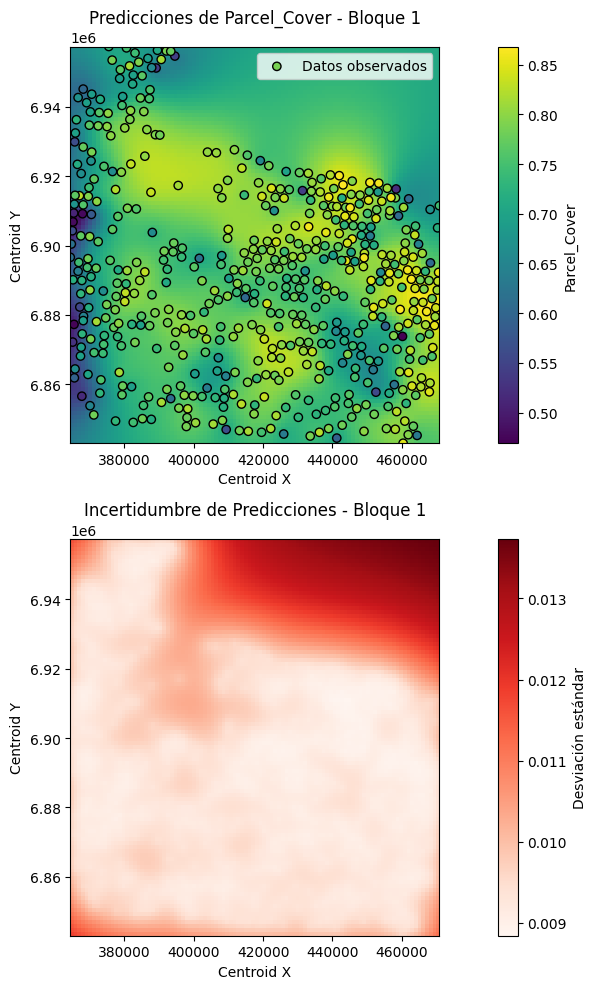

Procesando bloque 2...


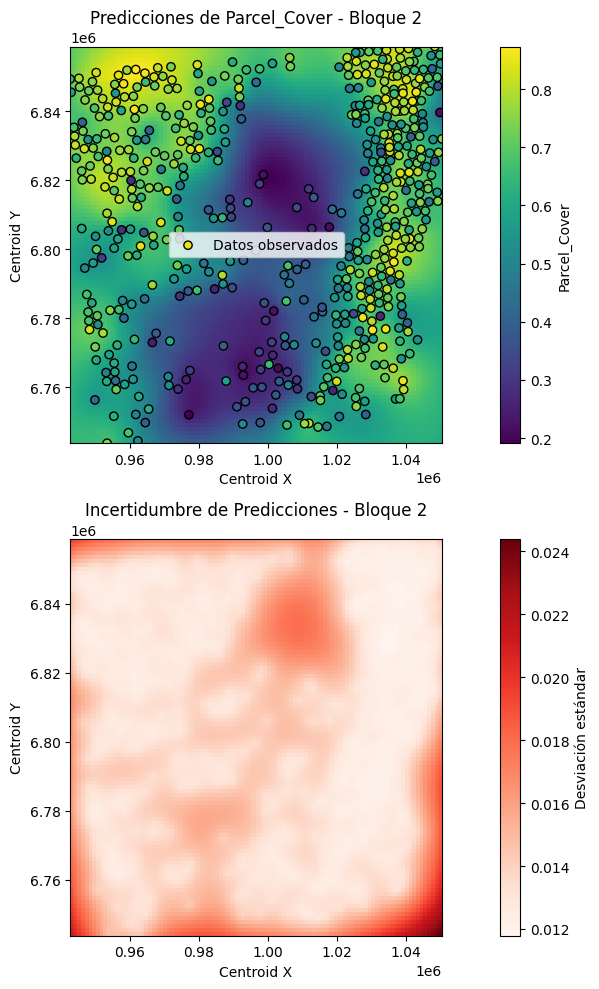

Procesando bloque 3...


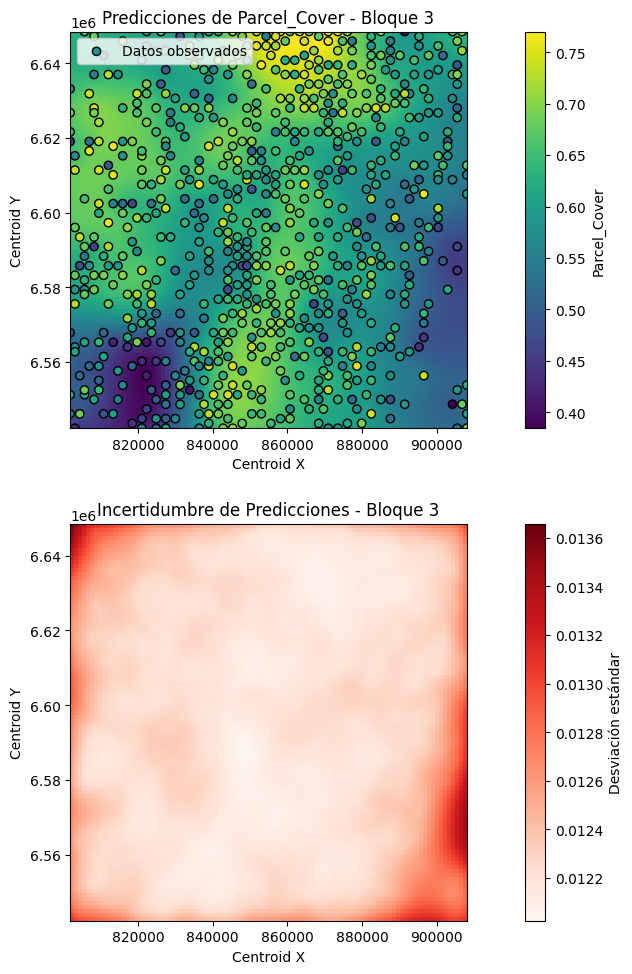

Procesando bloque 4...


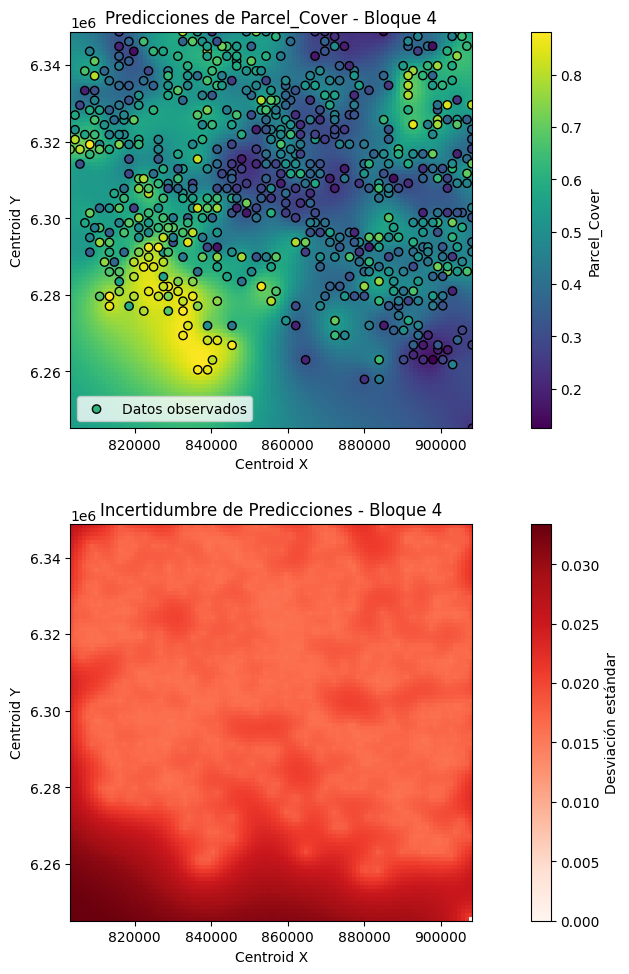

In [51]:
from pykrige.ok import OrdinaryKriging

# Parámetros óptimos por bloque
block_models = {
    1: {"model": "exponential", "params": [7.91180550e-03, 1.33948099e-02, 6.91840550e+04]},
    2: {"model": "spherical", "params": [1.02742059e-02, 2.77513207e-02, 4.89516746e+04]},
    3: {"model": "spherical", "params": [1.13390242e-02, 1.66620462e-02, 7.16888034e+04]},
    4: {"model": "exponential", "params": [1.26584776e-02, 3.24964061e-02, 4.59212052e+04]}
}

# Función para realizar kriging
def perform_kriging(block, metadata_df, block_models):
    # Filtrar datos para el bloque actual
    block_data = metadata_df[metadata_df["Block"] == block].dropna()
    coordinates = block_data[["centroid_x", "centroid_y"]].values
    values = block_data["Parcel_Cover"].values

    # Obtener el modelo y parámetros para el bloque
    model_info = block_models[block]
    variogram_model = model_info["model"]
    params = model_info["params"]
    
    # Ajustar parámetros para Matern
    if variogram_model == "matern":
        nugget, sill, range_, nu = params
        variogram_parameters = {"nugget": nugget, "sill": sill, "range": range_, "nu": nu}
    else:
        nugget, sill, range_ = params
        variogram_parameters = {"nugget": nugget, "sill": sill, "range": range_}

    # Crear modelo de kriging
    ok = OrdinaryKriging(
        coordinates[:, 0], coordinates[:, 1], values,
        variogram_model=variogram_model,
        variogram_parameters=variogram_parameters
    )

    # Crear cuadrícula para predicción
    gridx = np.linspace(block_data["centroid_x"].min(), block_data["centroid_x"].max(), 100)
    gridy = np.linspace(block_data["centroid_y"].min(), block_data["centroid_y"].max(), 100)
    
    # Realizar predicción
    z, ss = ok.execute("grid", gridx, gridy)
    return gridx, gridy, z, ss, coordinates, values

# Función para graficar resultados
def plot_results(block, gridx, gridy, z, ss, coordinates, values):
    plt.figure(figsize=(12, 10))

    # Mapa de predicciones
    plt.subplot(2, 1, 1)
    plt.title(f"Predicciones de Parcel_Cover - Bloque {block}")
    plt.imshow(z, extent=(gridx.min(), gridx.max(), gridy.min(), gridy.max()), origin="lower", cmap="viridis")
    plt.colorbar(label="Parcel_Cover")
    plt.scatter(coordinates[:, 0], coordinates[:, 1], c=values, edgecolor='k', label="Datos observados")
    plt.legend()
    plt.xlabel("Centroid X")
    plt.ylabel("Centroid Y")

    # Mapa de incertidumbre
    plt.subplot(2, 1, 2)
    plt.title(f"Incertidumbre de Predicciones - Bloque {block}")
    plt.imshow(ss, extent=(gridx.min(), gridx.max(), gridy.min(), gridy.max()), origin="lower", cmap="Reds")
    plt.colorbar(label="Desviación estándar")
    plt.xlabel("Centroid X")
    plt.ylabel("Centroid Y")

    plt.tight_layout()
    plt.show()

# Proceso para cada bloque
for block in block_models.keys():
    print(f"Procesando bloque {block}...")
    gridx, gridy, z, ss, coordinates, values = perform_kriging(block, metadata_df, block_models)
    plot_results(block, gridx, gridy, z, ss, coordinates, values)
